In [1]:
import scanpy as sc
import pandas as pd
from pathlib import Path
import anndata as ad
import numpy as np
import os
import scvi

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

DPI = 300
FONTSIZE = 20  # 42

sc.settings.set_figure_params(
    scanpy=True, dpi=100, transparent=True, vector_friendly=True, dpi_save=DPI
)
from matplotlib import rcParams

rcParams["pdf.fonttype"] = 42

Global seed set to 0


In [2]:
DIR2SAVE = Path(
    "/data/BCI-CRC/nasrine/data/CRC/Metastatic_CRC_LM_dataset/subpopulations/Endothelial"
)
DIR2SAVE.mkdir(parents=True, exist_ok=True)

In [3]:
FIG2SAVE = DIR2SAVE.joinpath("figures/")
FIG2SAVE.mkdir(parents=True, exist_ok=True)
# set the global variable: sc.settings.figdir to save all plots
sc.settings.figdir = FIG2SAVE

In [4]:
adata = sc.read_h5ad(
    DIR2SAVE.joinpath("Multiome_Che_Wu_CRC_LM_integrated_scvi_hvg_Endothelial.h5ad")
)

In [5]:
adata

AnnData object with n_obs × n_vars = 557 × 2000
    obs: 'Patient', 'Sample', 'Cell_type', 'Cell_subtype', 'Tissue', 'Therapy', 'doublet_score', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 'cell_source', 'Annotation_scVI', 'S_score', 'G2M_score', 'phase', 'cell_cycle_diff', '_scvi_batch', '_scvi_labels'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'Cell_type_colors', 'Therapy_colors', 'Tissue_colors', '_scvi_manager_uuid', '_scvi_uuid', 'cell_source_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    varm: 'PCs'
    layers: 'log1p', 'normalised', 'raw', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

In [6]:
adata.obs.cell_source.value_counts()

BCI-Nuclei    489
Che-Cells      68
Name: cell_source, dtype: int64

### Leiden clustering

In [7]:
adata.uns["neighbors"]

OverloadedDict, wrapping:
	{'connectivities_key': 'connectivities', 'distances_key': 'distances', 'params': {'method': 'umap', 'metric': 'euclidean', 'n_neighbors': 15, 'n_pcs': 10, 'random_state': 7, 'use_rep': 'X_scVI'}}
With overloaded keys:
	['connectivities', 'distances'].

In [8]:
from collections import Counter


def clustering_leiden_resolution(adata2test, res_range):
    """
    Performs hyperparameter search for resolution in leiden clustering
    :param adata2test: AnnData frame
    :param res_range: range of values to evaluate: i.e. np.arange(0.1, 1.5, 0.05)
    """
    resolution_dict = {r: None for r in res_range}
    # vary resolution parameter and see which nb of clusters occurs more frequently
    for r in res_range:
        # load adata
        adata = adata2test.copy()
        sc.tl.leiden(adata, resolution=r, random_state=7)
        # store nb of clusters for that resolution
        resolution_dict[r] = len(set(adata.obs["leiden"]))

    # plot figure: nb clusters in fct of resolution param
    fig, ax = plt.subplots(
        nrows=1, ncols=1, sharey=False, sharex=False, dpi=DPI, figsize=(5, 4.5)
    )
    plt.scatter(resolution_dict.keys(), resolution_dict.values())
    ax.set_xlabel("Resolution")
    ax.set_ylabel("Number of clusters")
    ax.tick_params(axis="both", which="major", labelsize=FONTSIZE - 10)
    plt.show()

    # display nb of times each number of clusters occurs
    print("Frequency of NB clusters")
    print(Counter(list(resolution_dict.values())))

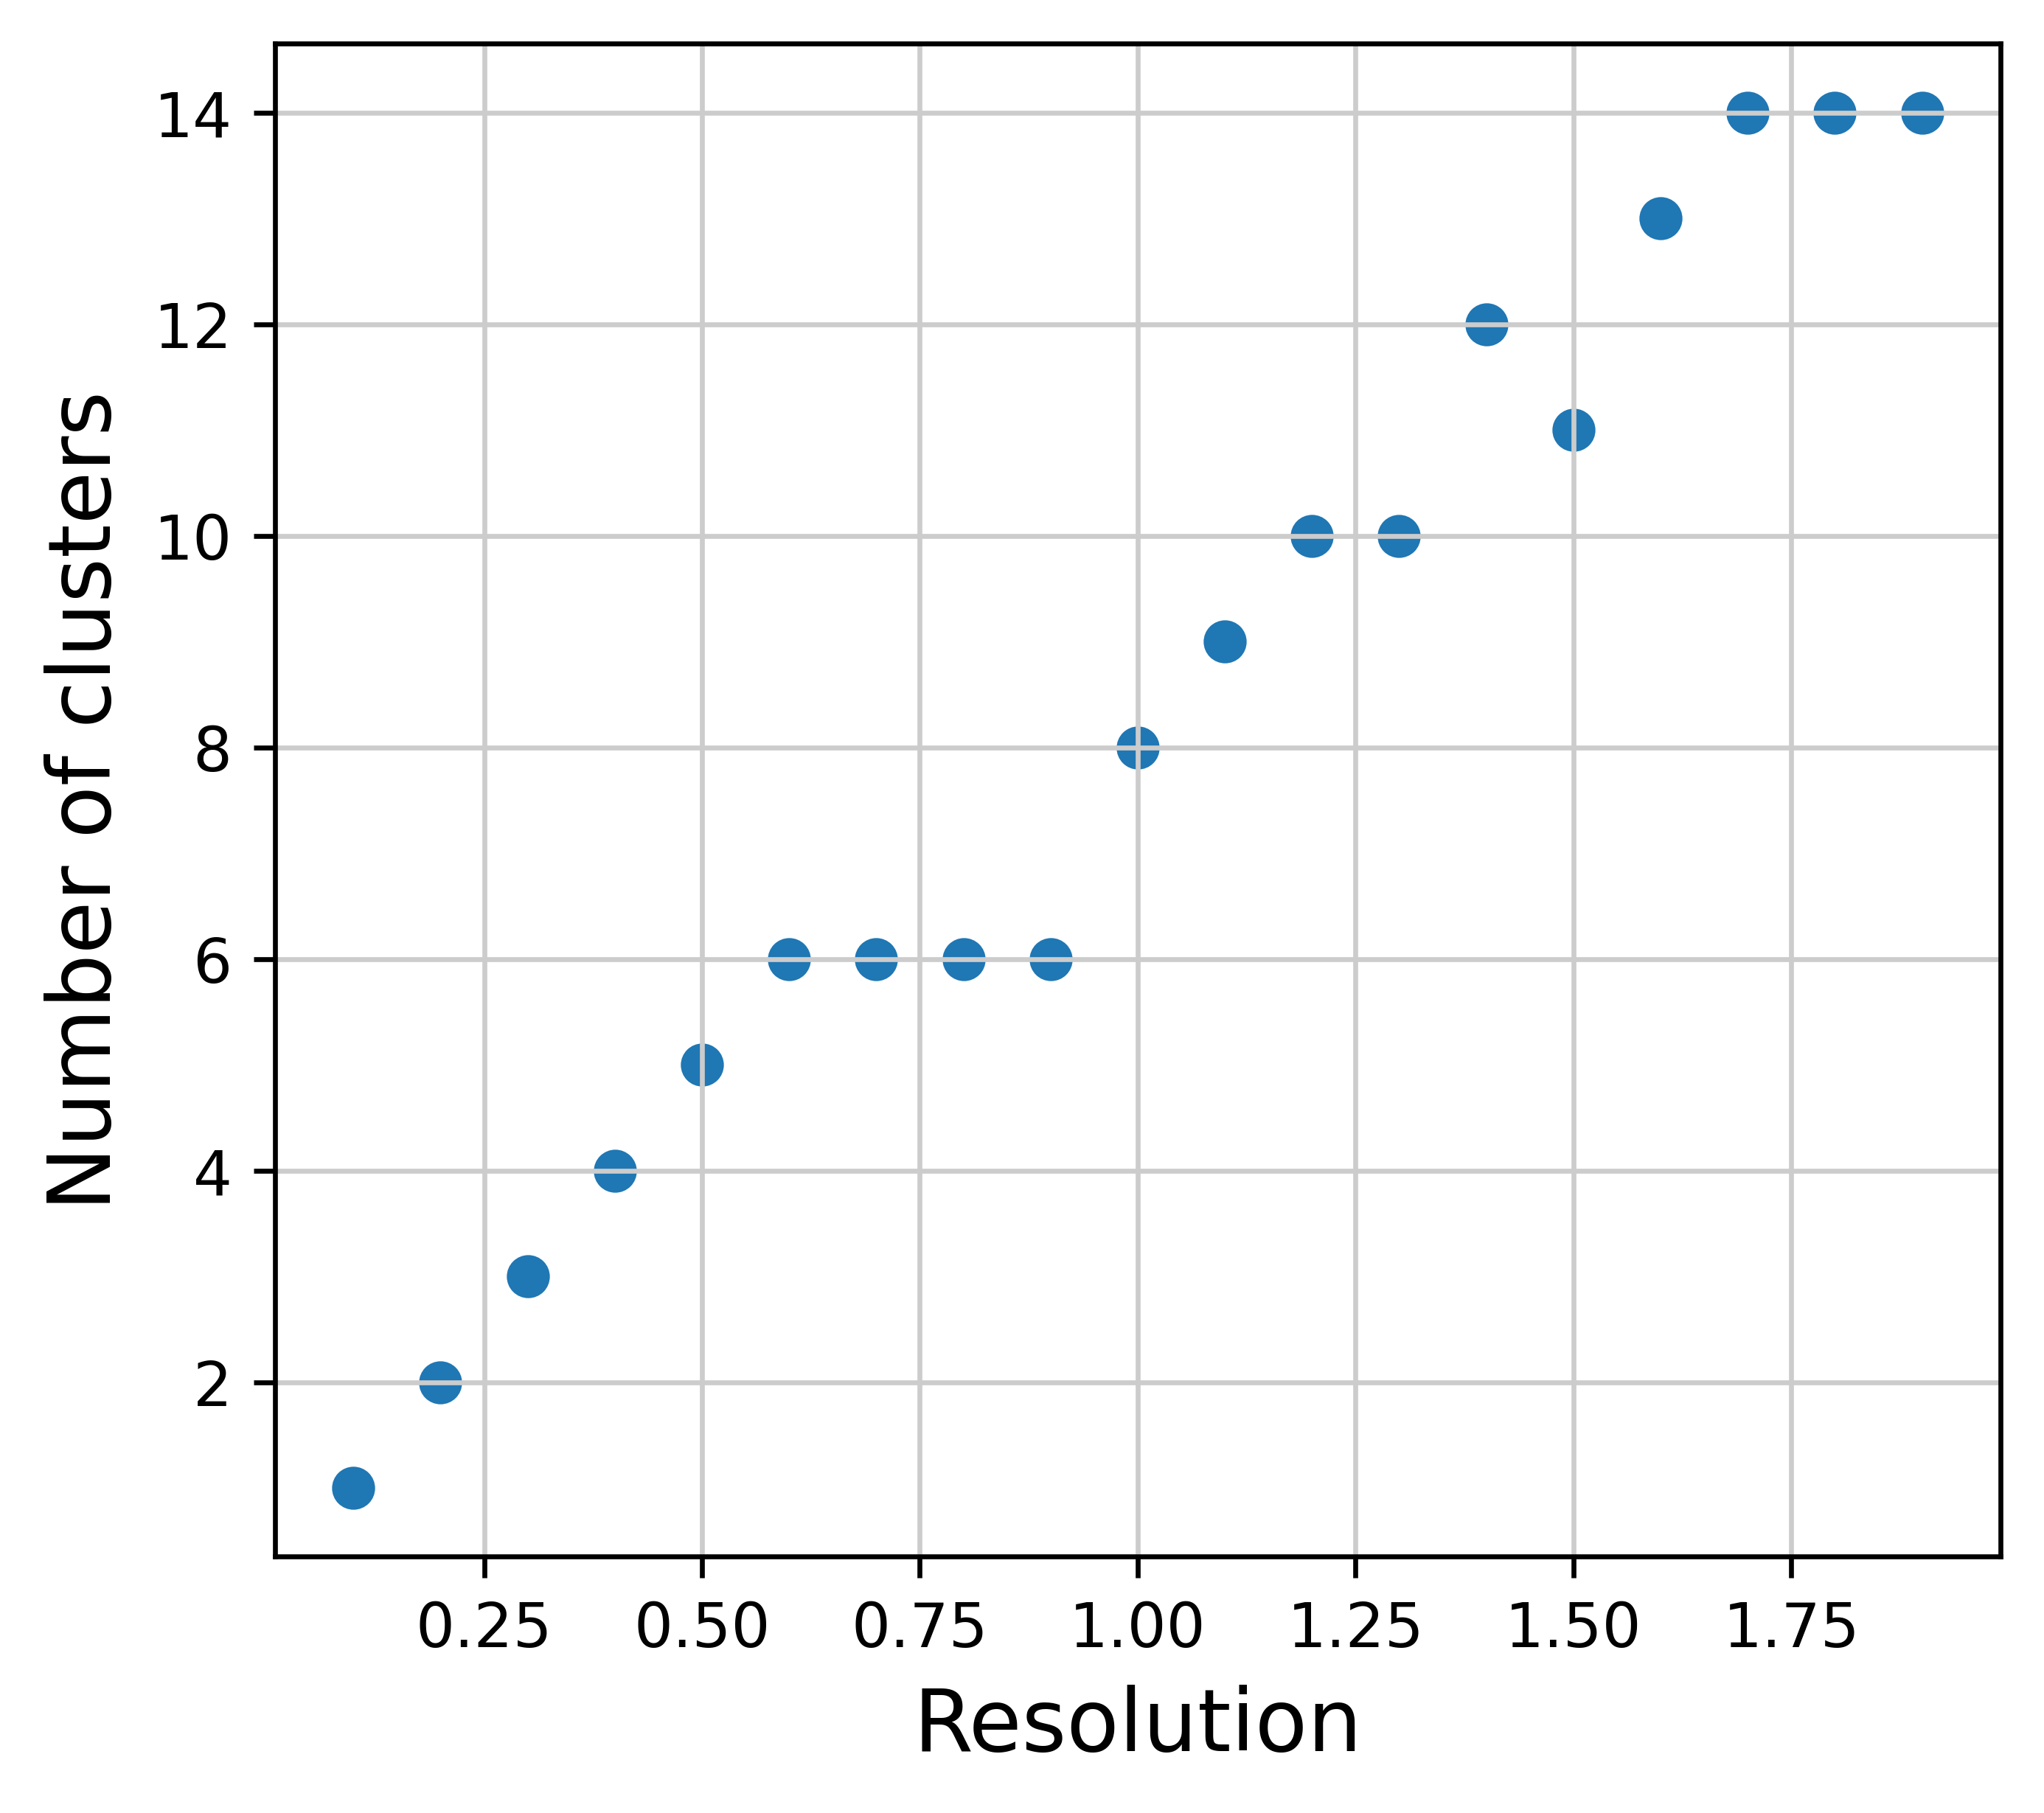

Frequency of NB clusters
Counter({6: 4, 14: 3, 10: 2, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 8: 1, 9: 1, 12: 1, 11: 1, 13: 1})


In [9]:
clustering_leiden_resolution(adata, res_range=np.arange(0.1, 2, 0.1))

In [10]:
# neighbors were already computed using Harmony corrected PCs, so we perform clustering on that graph
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.75, random_state=7)

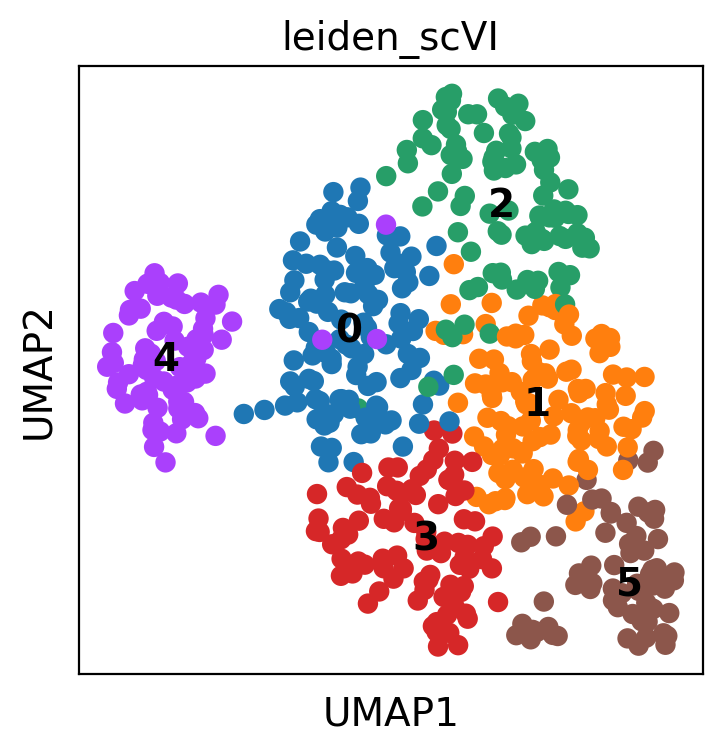

In [11]:
sc.pl.umap(
    adata,
    color="leiden_scVI",
    legend_loc="on data",
    save="general_clustering.pdf",
    show=True,
)

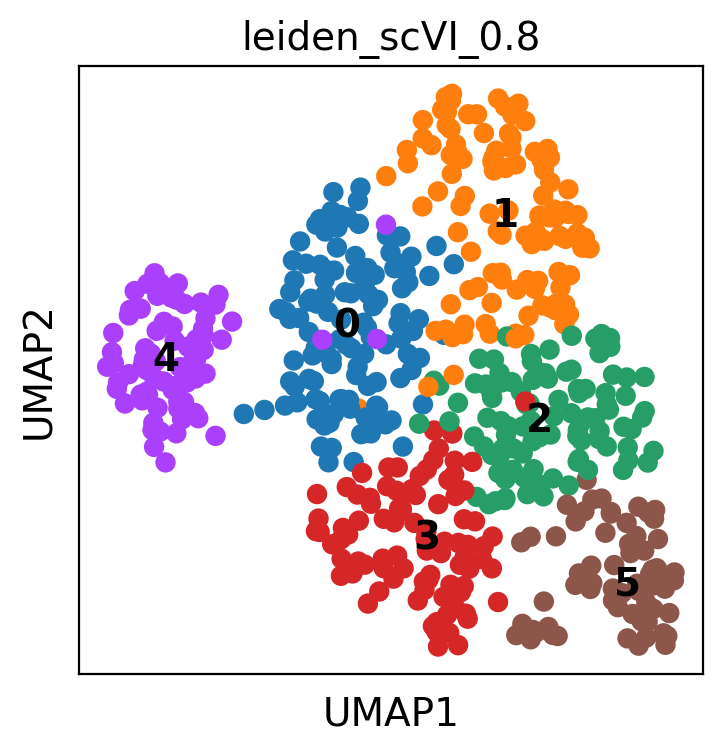

In [12]:
# neighbors were already computed using Harmony corrected PCs, so we perform clustering on that graph
sc.tl.leiden(adata, key_added="leiden_scVI_0.8", resolution=0.8, random_state=7)
sc.pl.umap(adata, color="leiden_scVI_0.8", legend_loc="on data", show=True)

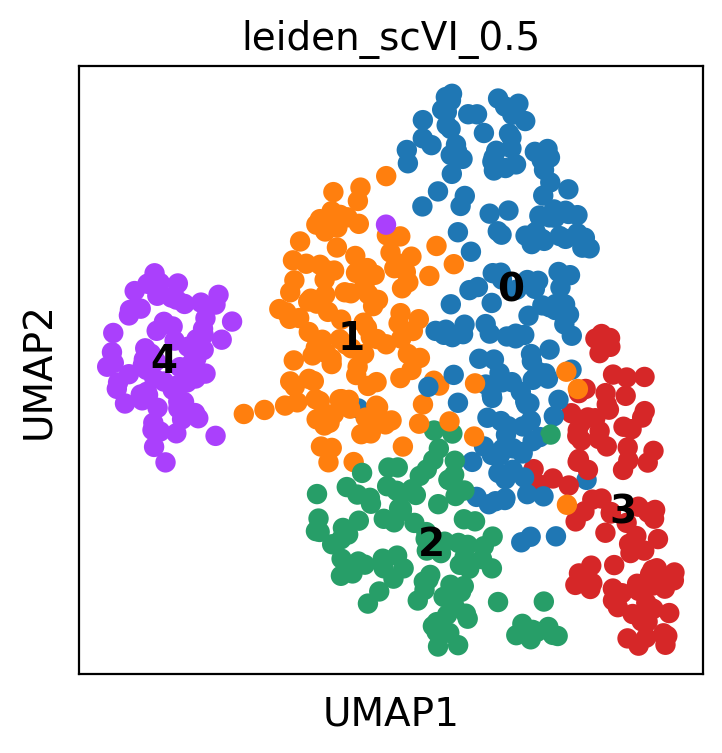

In [13]:
# neighbors were already computed using Harmony corrected PCs, so we perform clustering on that graph
sc.tl.leiden(adata, key_added="leiden_scVI_0.5", resolution=0.5, random_state=7)
sc.pl.umap(adata, color="leiden_scVI_0.5", legend_loc="on data", show=True)

In [14]:
adata.obs.Patient.value_counts()

CRC13    127
CRC08     77
CRC02     56
CRC10     42
COL18     40
CRC14     36
CRC06     33
CRC12     26
CRC15     25
COL15     19
CRC03     17
CRC09     15
CRC04     14
CRC11     14
COL17      5
CRC01      4
COL12      4
CRC05      3
Name: Patient, dtype: int64

In [15]:
adata.obs.leiden_scVI.value_counts()

0    120
1    114
2     93
3     91
4     73
5     66
Name: leiden_scVI, dtype: int64

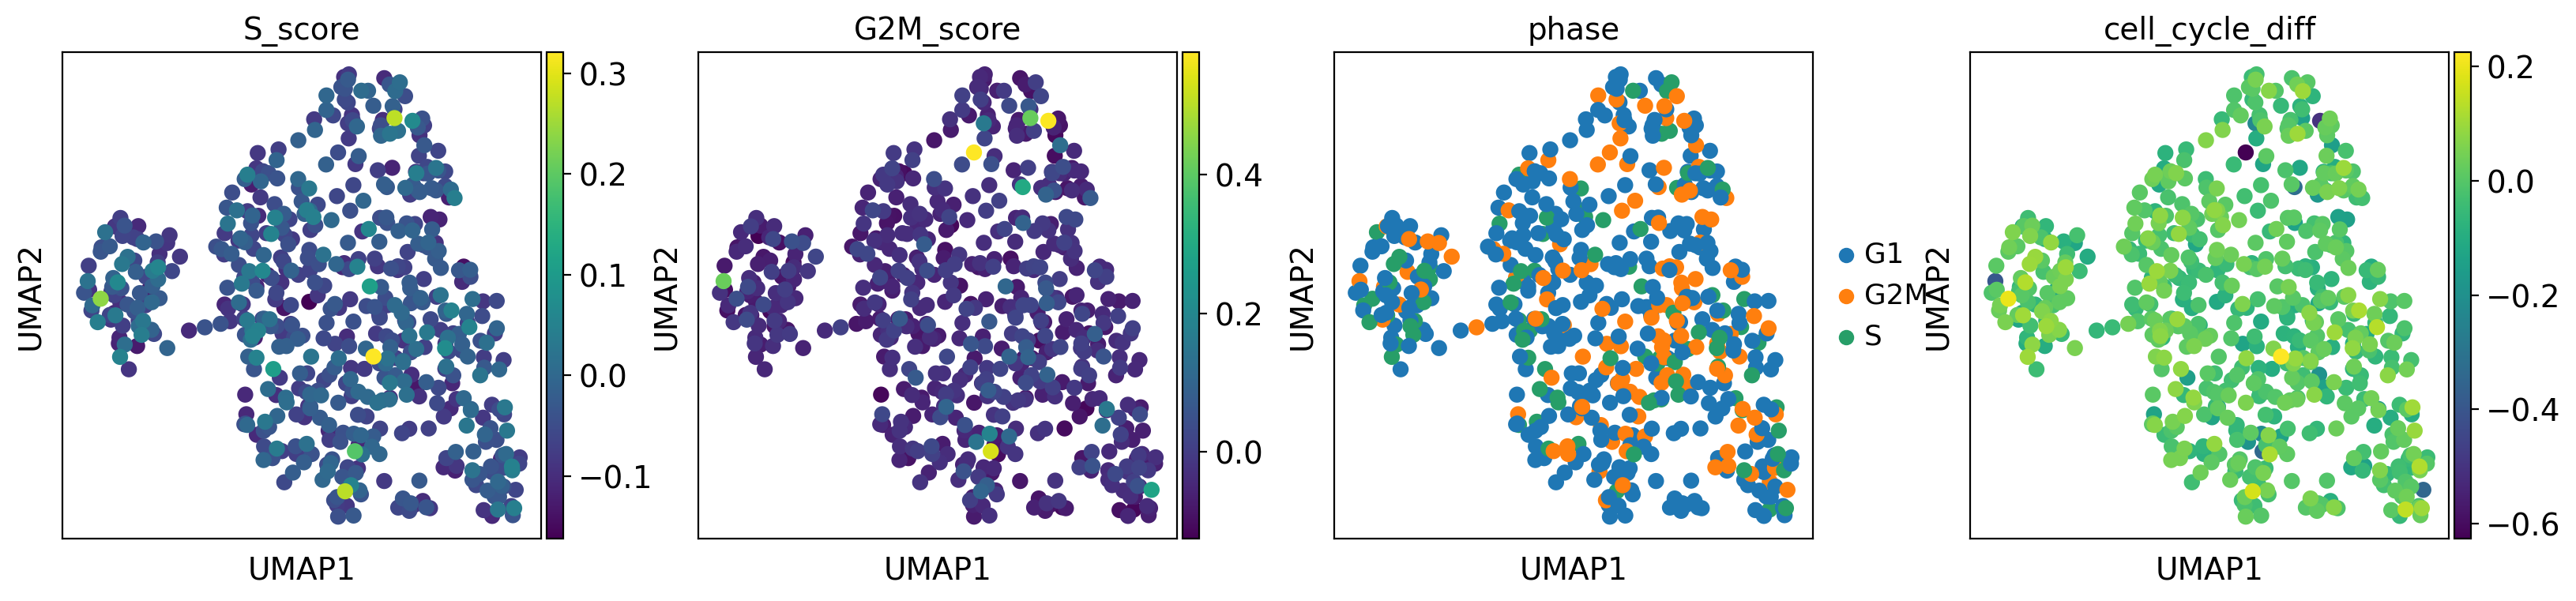

In [16]:
sc.pl.umap(
    adata,
    color=["S_score", "G2M_score", "phase", "cell_cycle_diff"],
    color_map="viridis",
    save="cell_cycle.pdf",
)

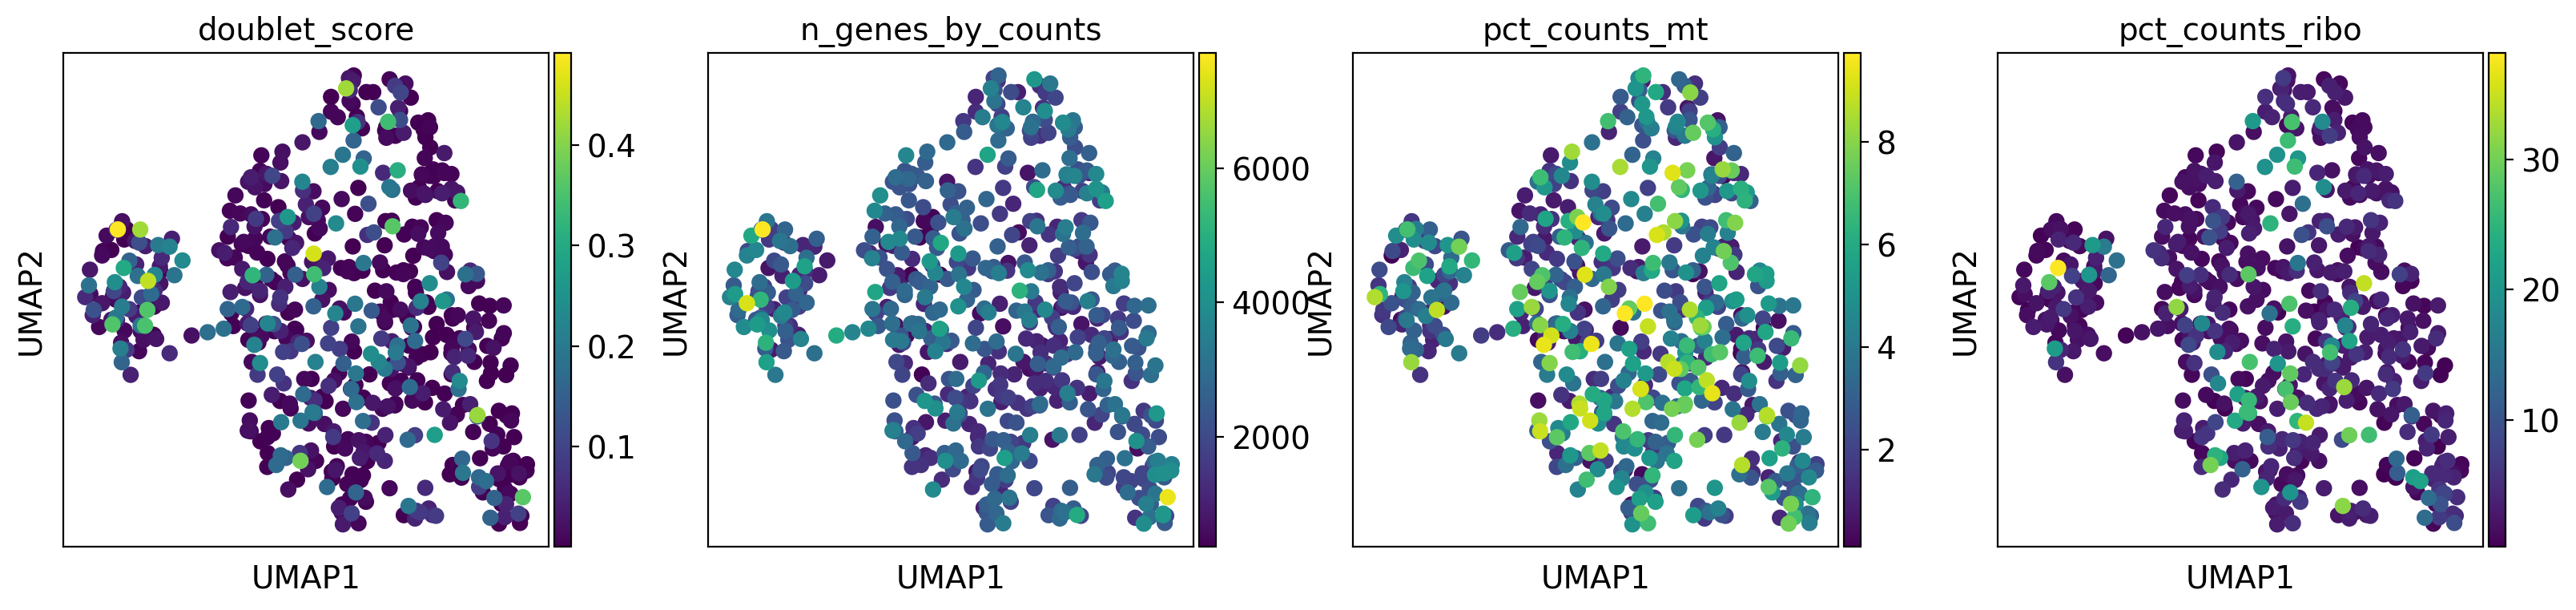

In [17]:
sc.pl.umap(
    adata,
    color=["doublet_score", "n_genes_by_counts", "pct_counts_mt", "pct_counts_ribo"],
    color_map="viridis",
    save="QC_covariates.pdf",
)

### Plot some markers 

**From "A human liver cell atlas reveals heterogeneity and epithelial progenitors, Nature paper":**

> In the normal liver, LSECs line the sinusoids of the liver lobule and are
CLEC4G+PECAM1low
, while MaVECs line the hepatic arteries and veins and are
CD34+PECAM1high cells

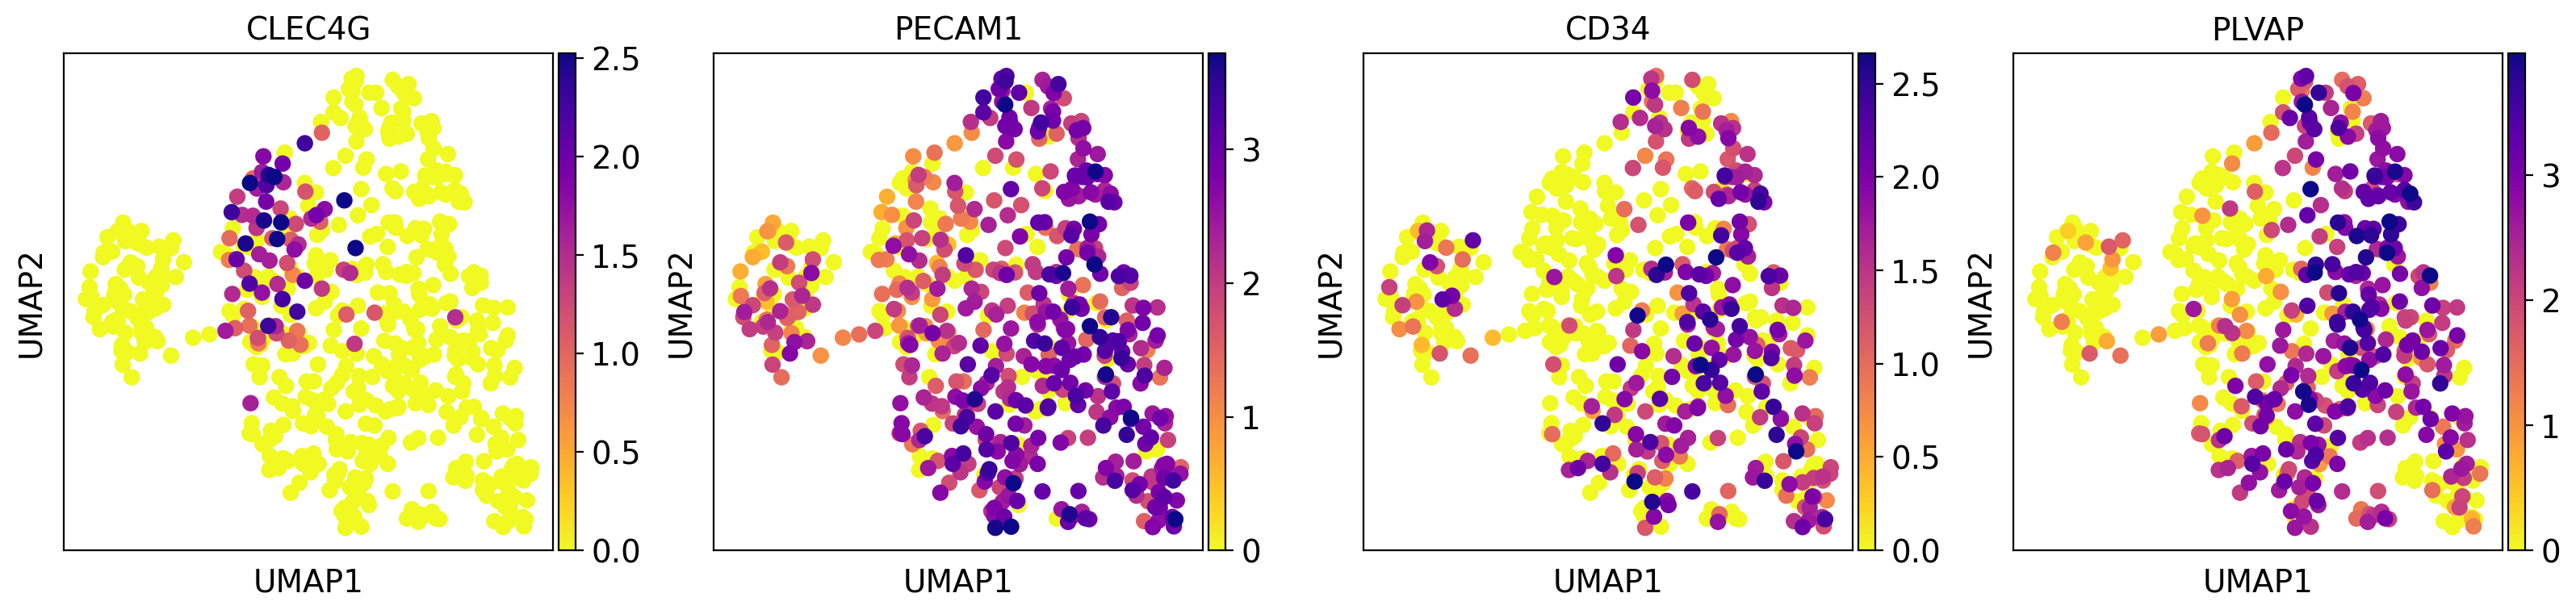

In [5]:
sc.pl.umap(
    adata,
    color=["CLEC4G", "PECAM1", "CD34", "PLVAP"],
    use_raw=True,
    vmin=0.0,
    vmax="p99",
    color_map="plasma_r",  #'RdPu',
    save="LSECs_vs_VECs.pdf",
    show=True,
)

We can see that our data divides into two general subsets: 
   * The macrovascular endothelial cells (MaVECs) 
   * the liver sinusoidal endothelial cells (LSECs).

Cluster 0 is Sinusoidal endothelial cell 
The rest is MaVECs

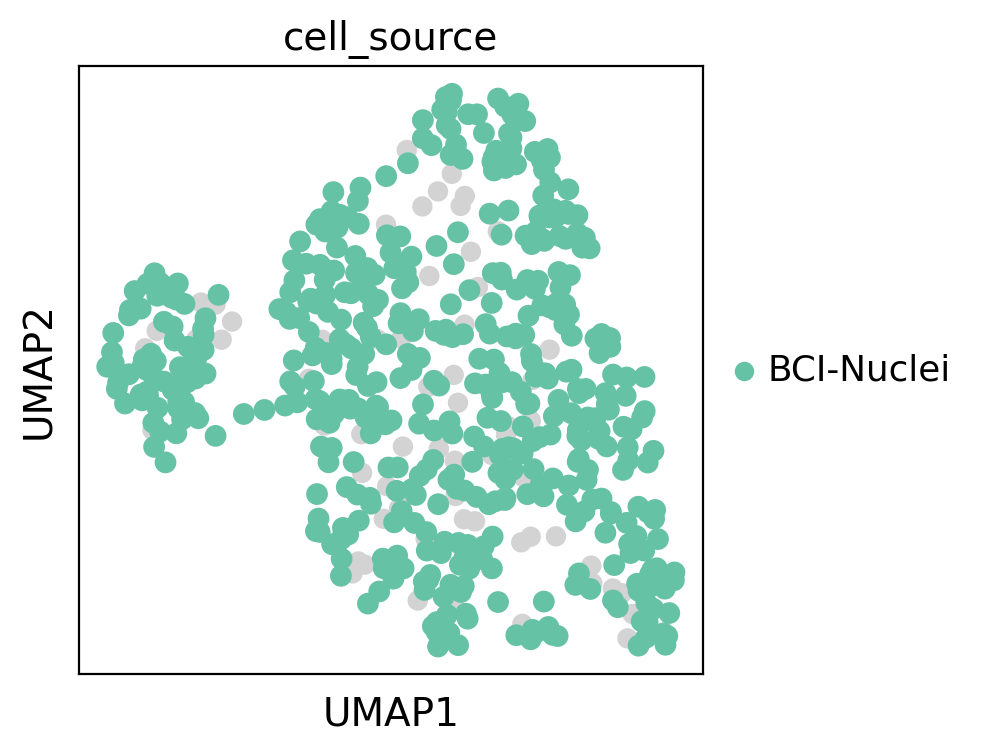

In [19]:
ax = sc.pl.umap(adata, show=False)
sc.pl.umap(
    adata[adata.obs["cell_source"] == "BCI-Nuclei"],
    # size=10,
    color="cell_source",
    ax=ax,
)

In [6]:
markers = {
    "Endo": ["PECAM1"],
    "Lymph endo": ["LYVE1", "PROX1"],
    "Stalk": ["ACKR1", "SELP"],
    "Tip": ["RGCC", "KDR"],
    "Enteric glial": ["S100B", "PLP1"],
    "Prolif endo": ["BIRC5", "MKI67"],
    "SEC": ["FCN3", "FCN2", "CLEC4G"],  # 'F8', 'CD9', 'SPARCL1', 'TM4SF1']
}

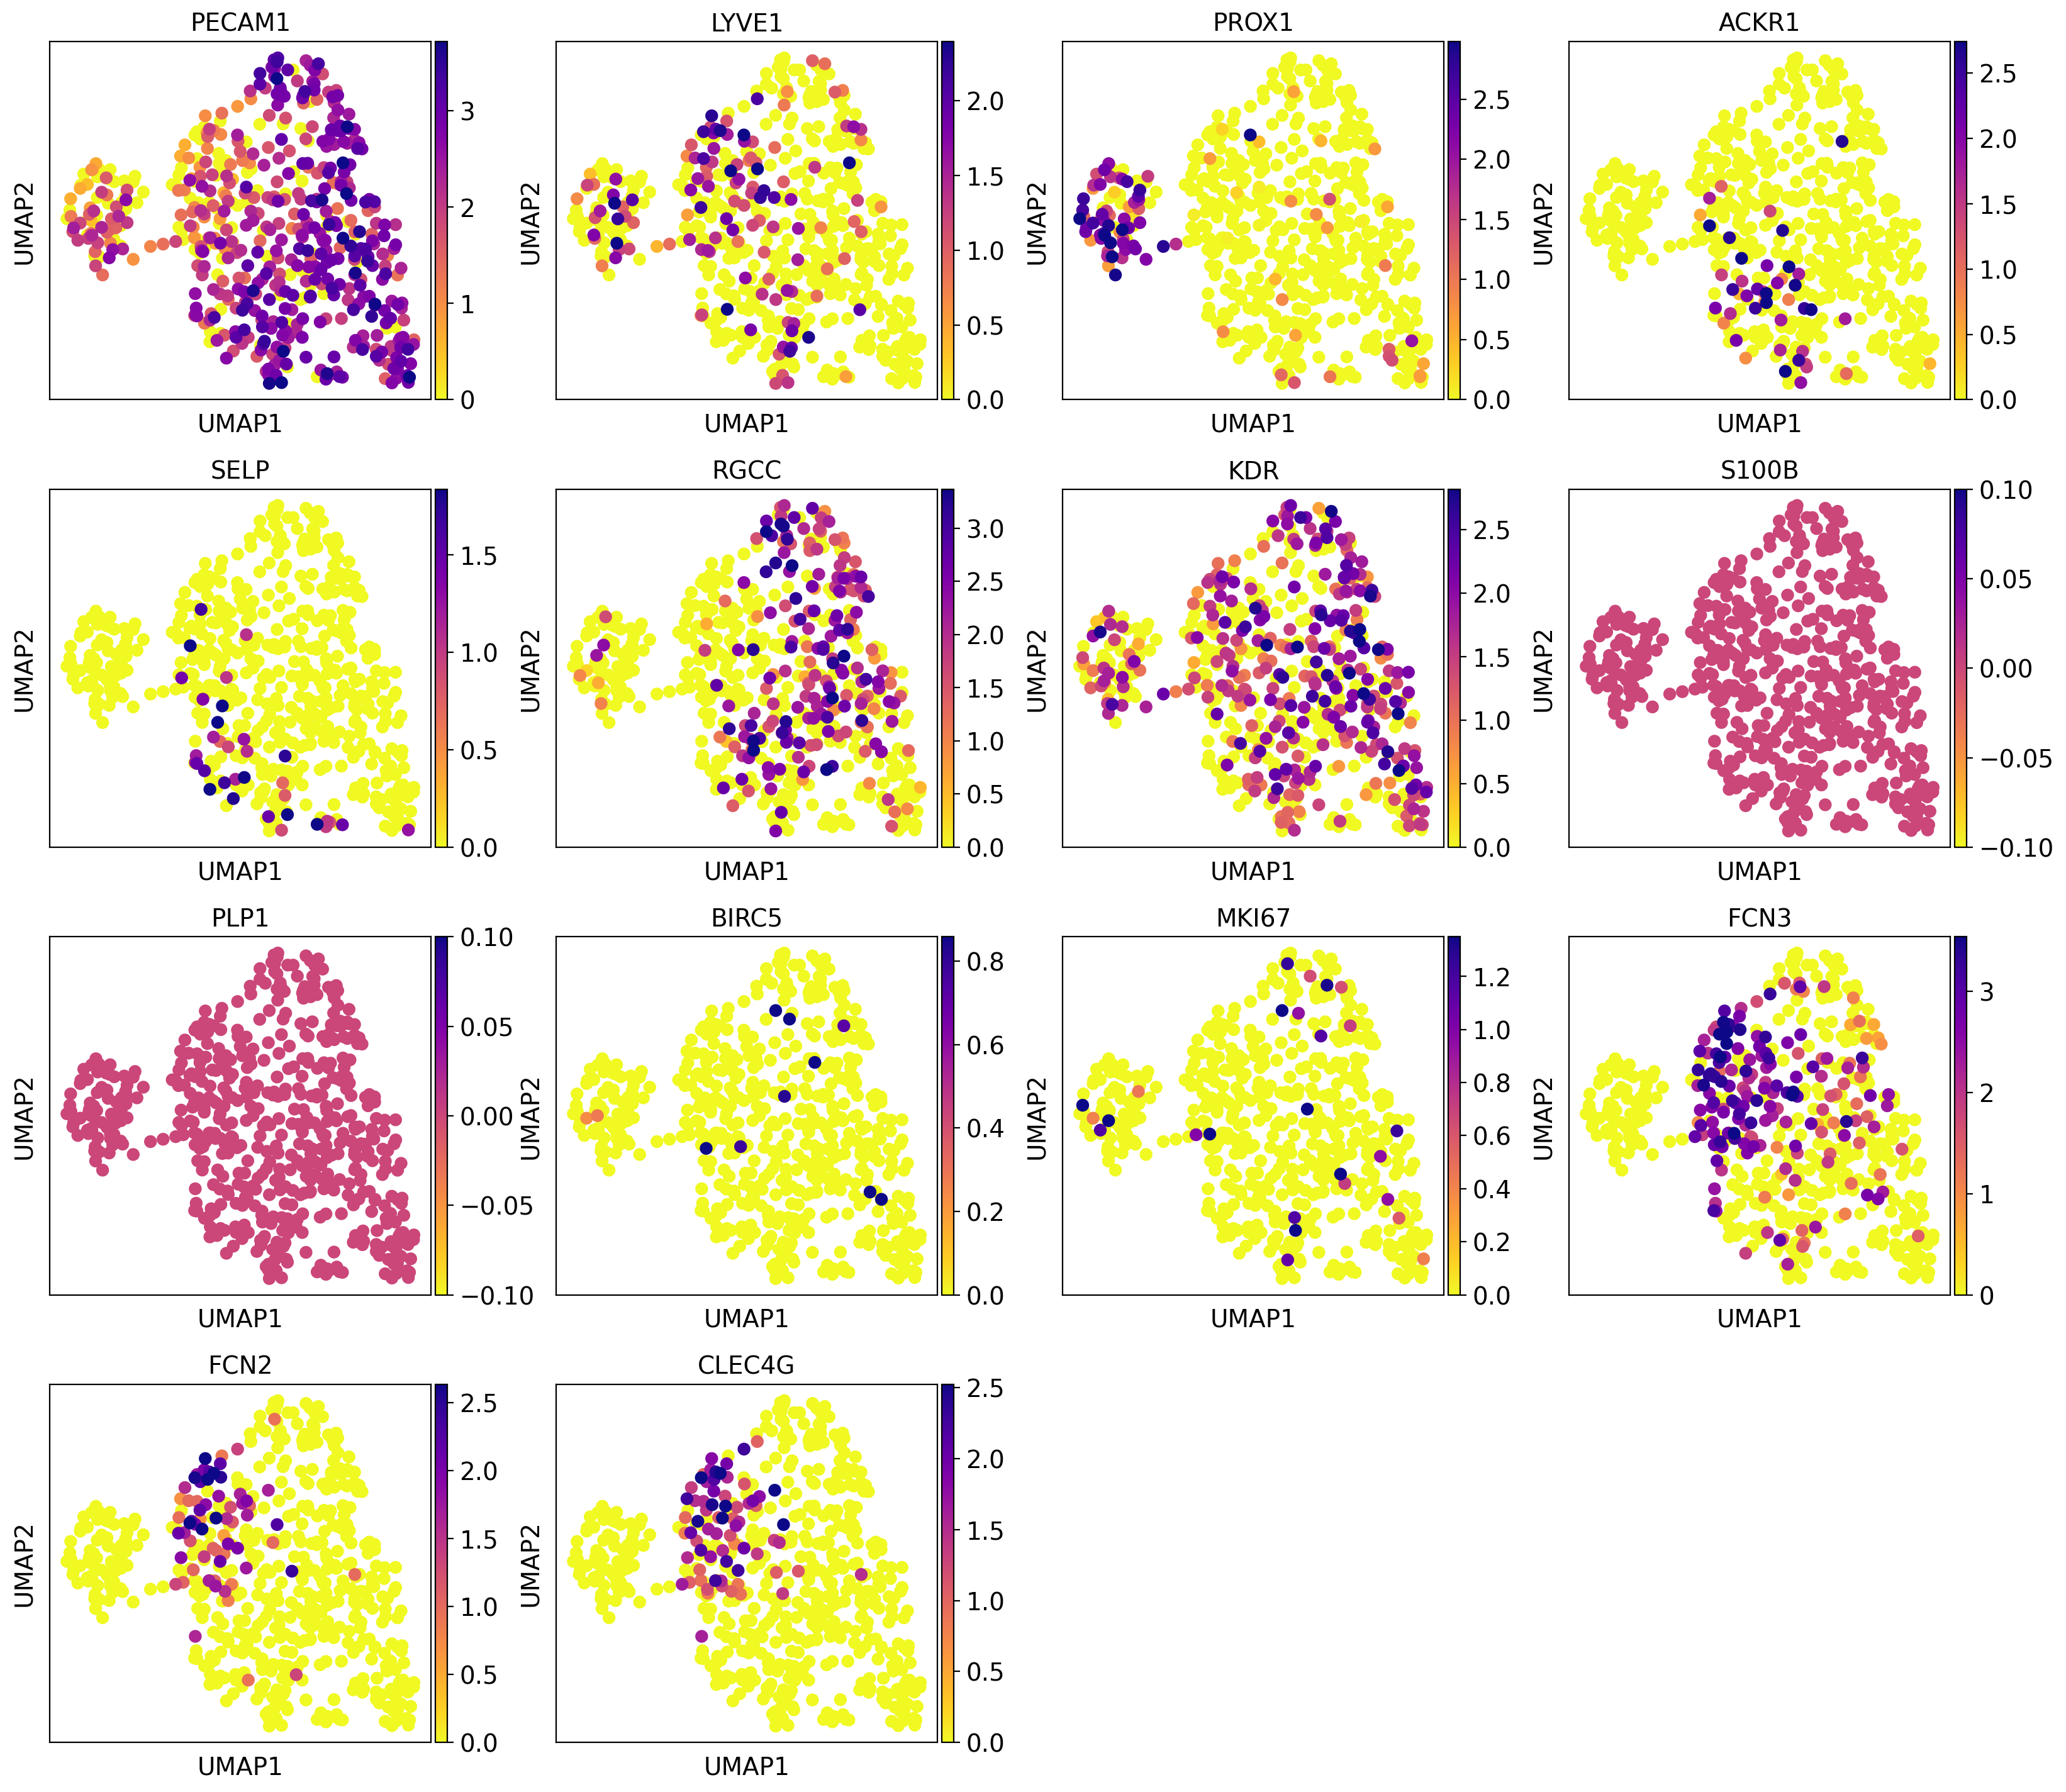

In [7]:
import itertools

# use log1p data stored in .raw
markers2plot = list(
    itertools.chain(*list(markers.values()))
)  # get all markers in a single list
sc.pl.umap(
    adata,
    color=markers2plot,
    use_raw=True,
    vmin=0.0,
    vmax="p99",
    color_map="plasma_r",  #'RdPu',
    save="general_markers.pdf",
    show=True,
)

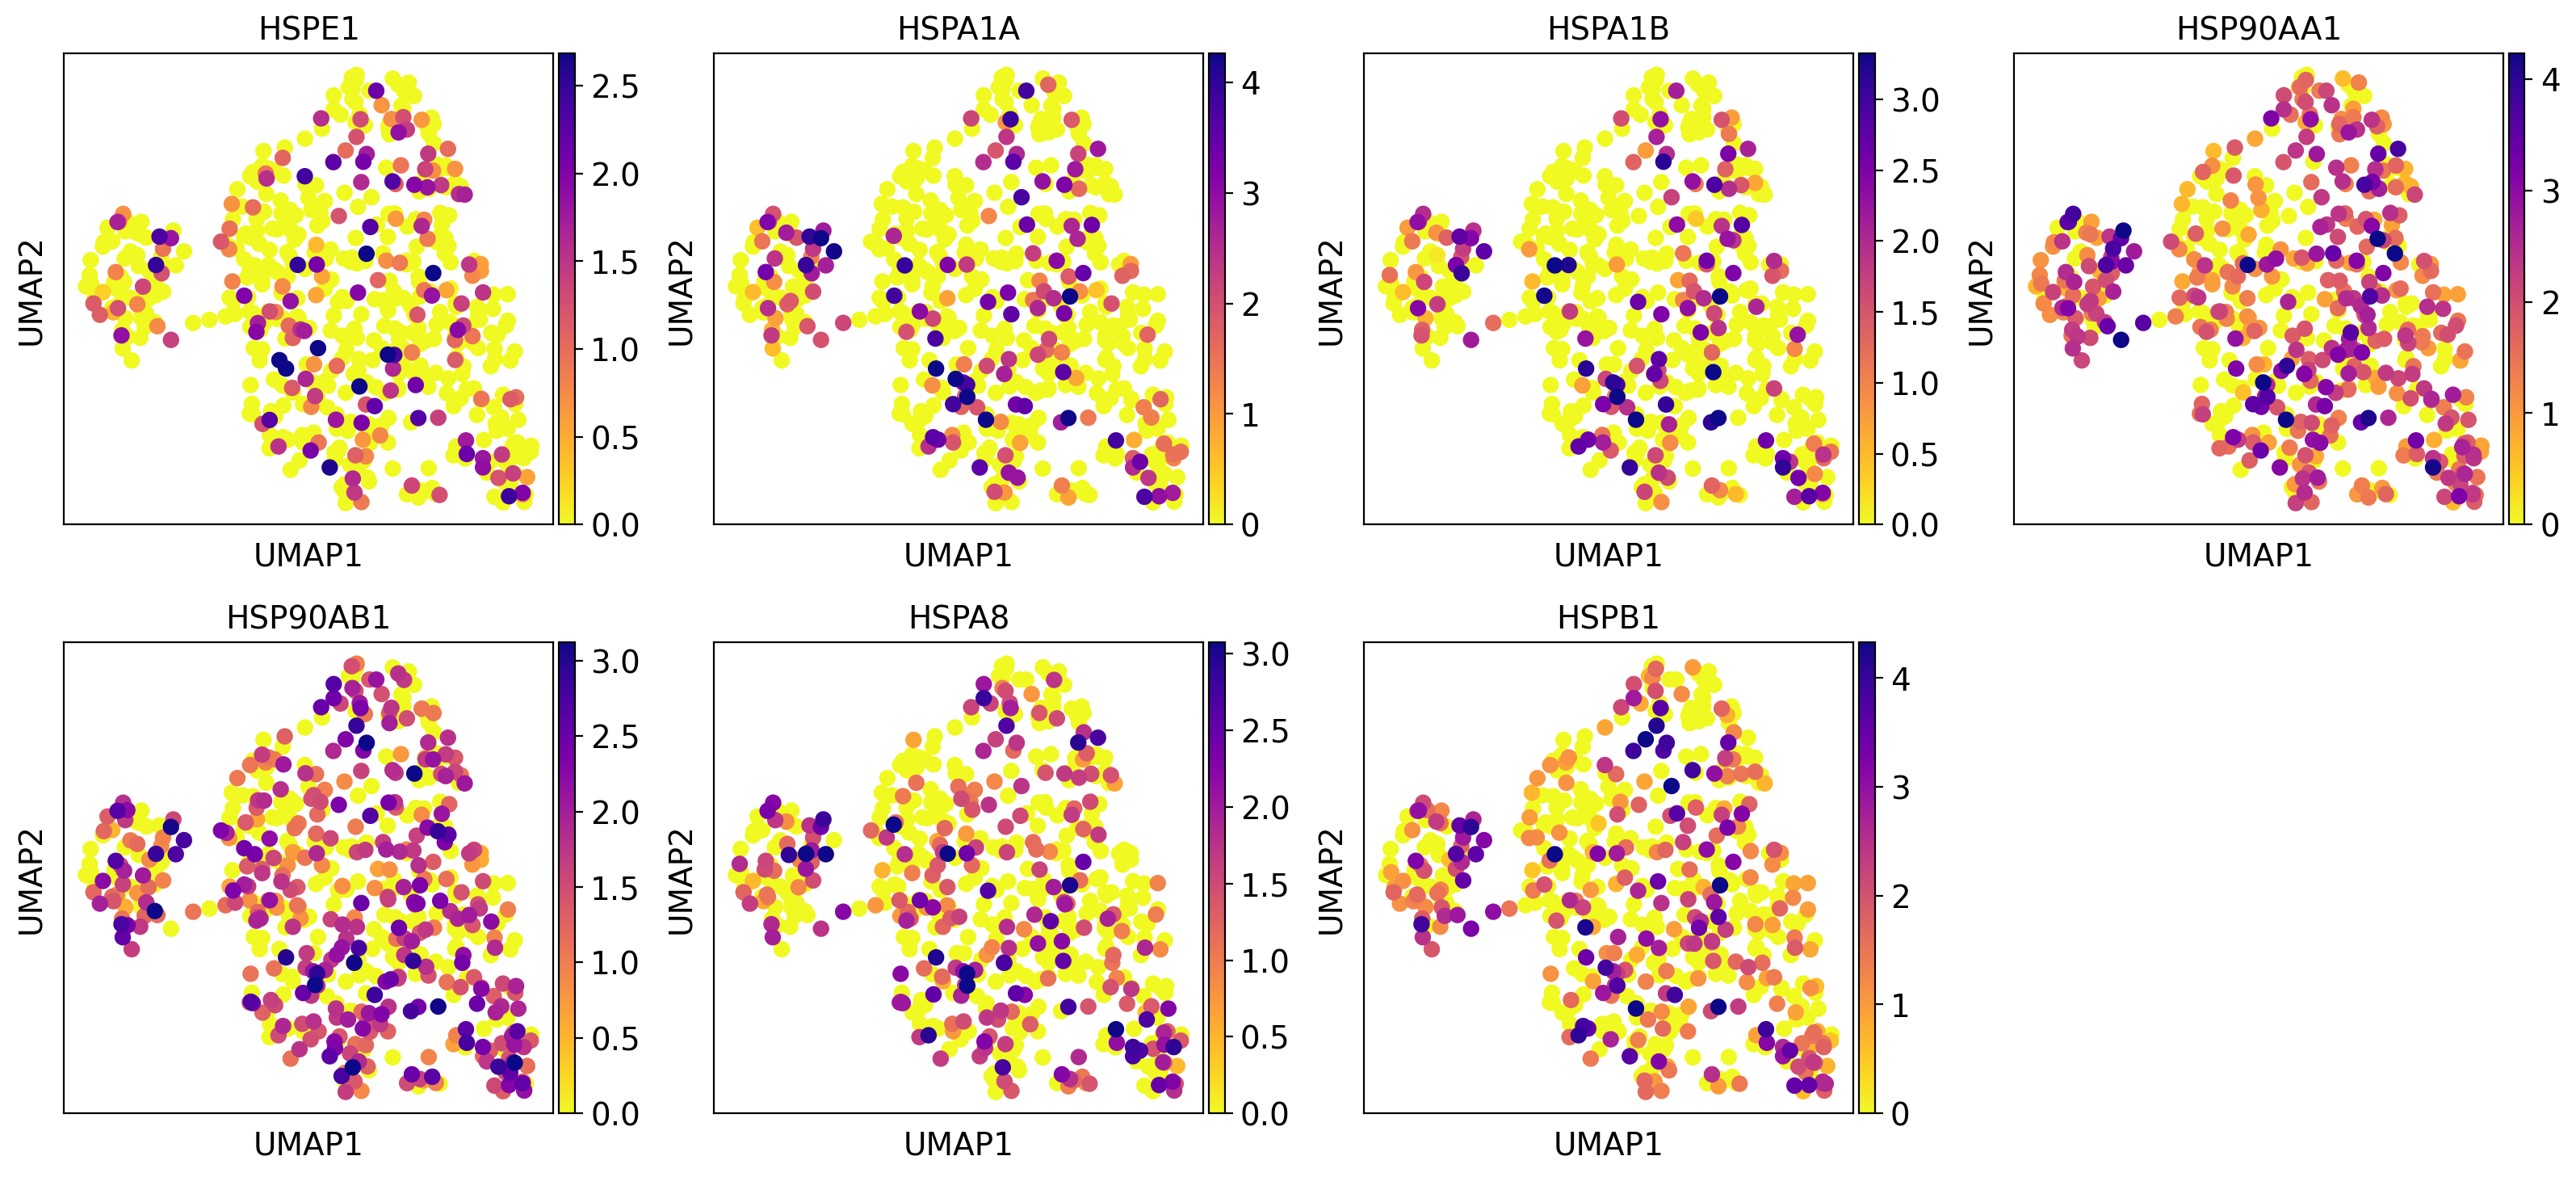

In [8]:
### markers for stress
# HSP
dissocation_markers_dict = {
    "shock protein": [
        "HSPE1",
        "HSPA1A",
        "HSPA1B",
        "HSP90AA1",
        "HSP90AB1",
        "HSPA8",
        "HSPB1",
    ],
    "immediate early genes": ["FOS", "JUN"],
}

sc.pl.umap(
    adata,
    color=dissocation_markers_dict["shock protein"],
    vmax="p99",
    use_raw=True,
    vmin=0,
    color_map="plasma_r",
    save="general_HSPmarkers.pdf",
    show=True,
)

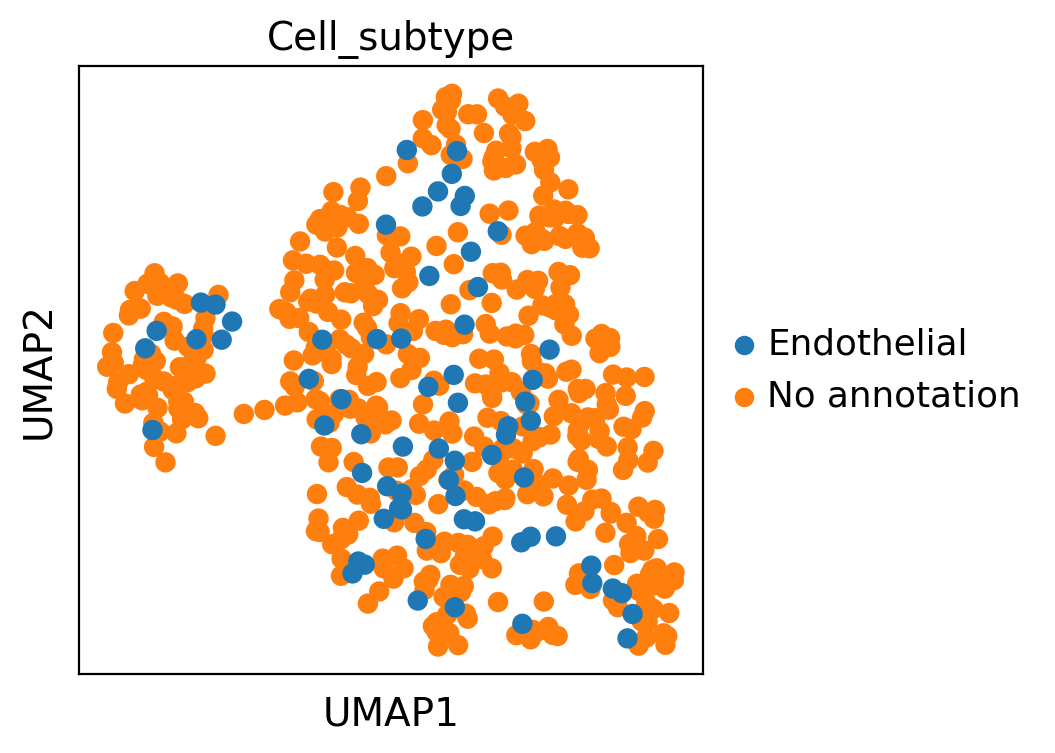

In [23]:
sc.pl.umap(adata, color="Cell_subtype")

### Differential expression to get DE genes upregulated per cluster 

In [24]:
# issue here https://github.com/theislab/single-cell-tutorial/issues/97
# This seems to be a scanpy bug as you can see here and here. The latter issue suggests to just add the line:
# adata.uns['log1p']["base"] = None after reading again, or downgrading to AnnData<0.8.
# Either way, this should be fixed soon by the maintenance team.
adata.uns["log1p"]["base"] = None

In [25]:
sc.tl.rank_genes_groups(
    adata,
    groupby="leiden_scVI",
    reference="rest",
    method="wilcoxon",
    use_raw=True,
    layer=None,
    pts=True,
    corr_method="benjamini-hochberg",
    key_added="rank_genes_wilcoxon",
)

categories: 0, 1, 2, etc.
var_group_labels: Endo, Lymph endo, Stalk, etc.


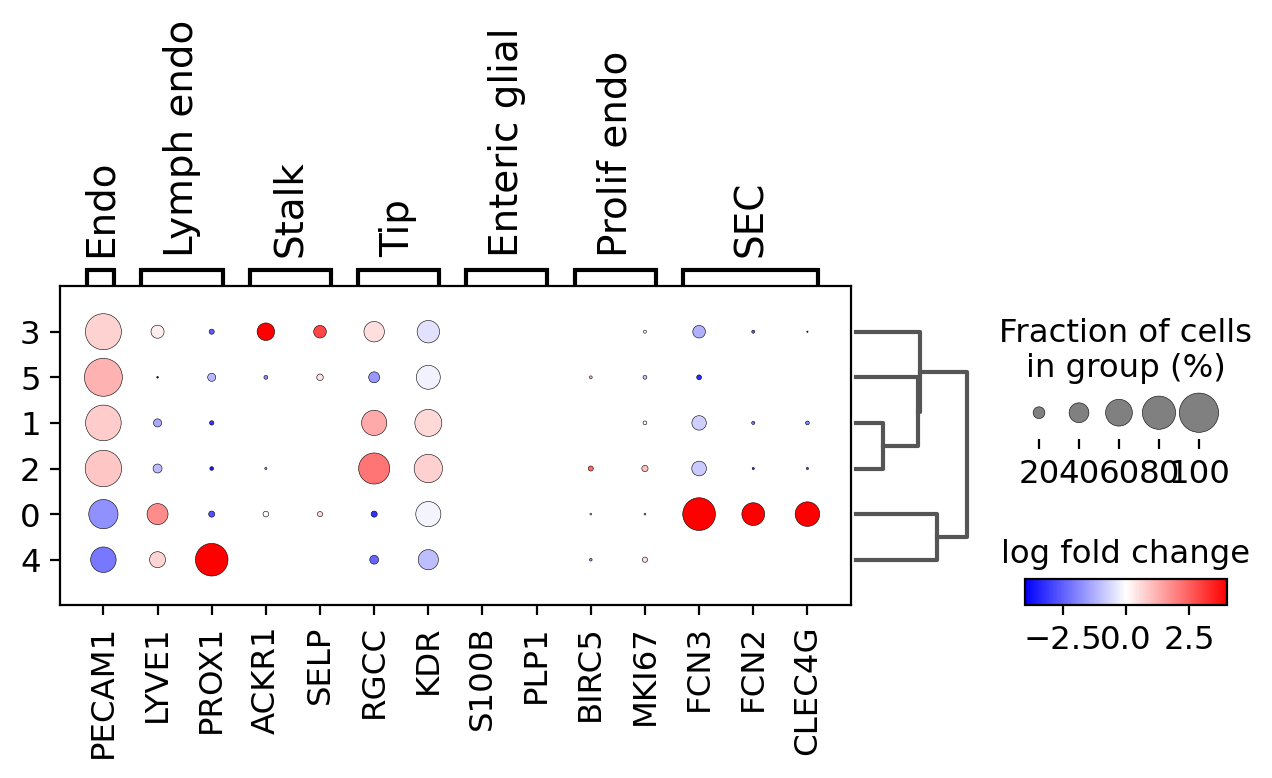

In [27]:
sc.pl.rank_genes_groups_dotplot(
    adata,
    groupby="leiden_scVI",
    key="rank_genes_wilcoxon",
    var_names=markers,
    values_to_plot="logfoldchanges",
    cmap="bwr",
    vmin=-4,
    vmax=4,
    min_logfoldchange=1,
    colorbar_title="log fold change",
    save="general_dotplot.pdf",
    show=True,
)

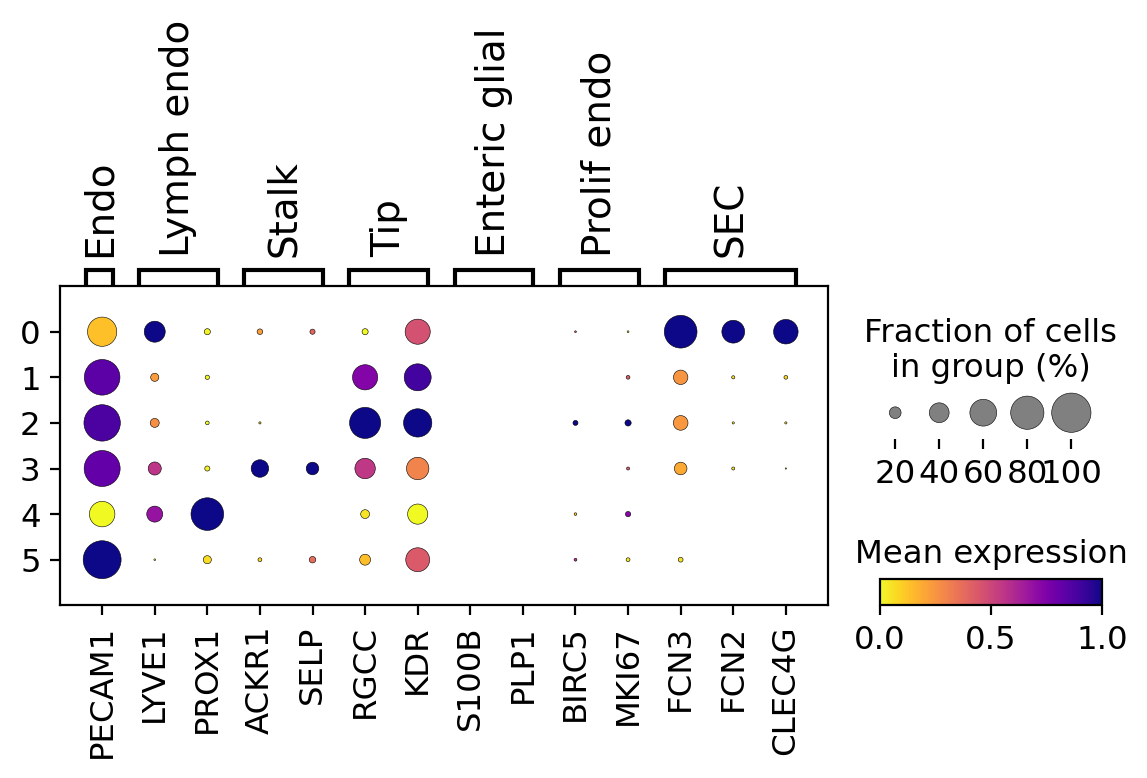

In [9]:
sc.pl.dotplot(
    adata,
    groupby="leiden_scVI",
    use_raw=True,
    var_names=markers,
    cmap="plasma_r",
    standard_scale="var",
    vmin=0,
    vmax=1,
    colorbar_title="Mean expression",
    dendrogram=False,
    save="dotplot_mean_general.pdf",
    show=True,
)

categories: 0, 1, 2, etc.
var_group_labels: shock protein, immediate early genes


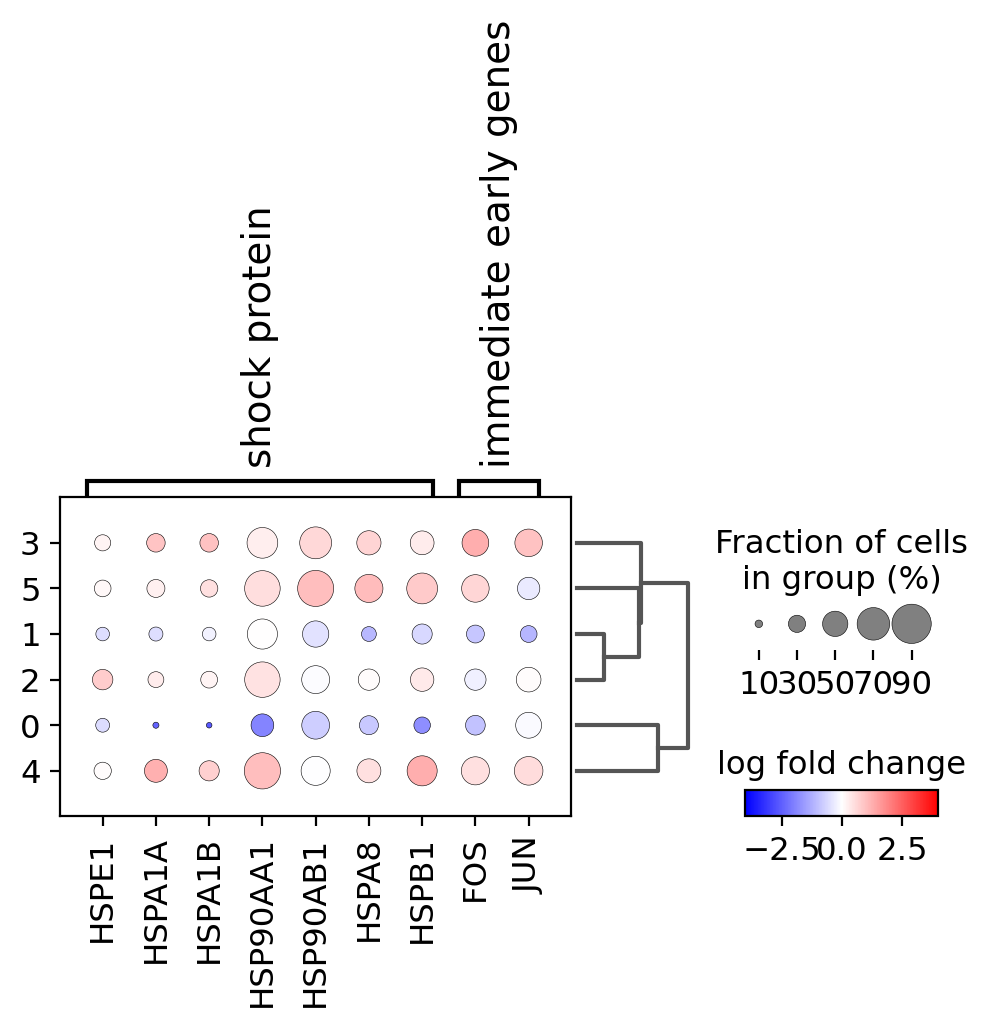

In [29]:
sc.pl.rank_genes_groups_dotplot(
    adata,
    groupby="leiden_scVI",
    key="rank_genes_wilcoxon",
    var_names=dissocation_markers_dict,
    values_to_plot="logfoldchanges",
    cmap="bwr",
    vmin=-4,
    vmax=4,
    min_logfoldchange=1,
    colorbar_title="log fold change",
    save="HSP_dotplot.pdf",
    show=True,
)

In [30]:
pval_thresh = 0.05
log2fc_thresh = 1
cluster_de_genes = dict()
for cluster in sorted(set(adata.obs["leiden_scVI"])):
    cluster_de_genes[cluster] = sc.get.rank_genes_groups_df(
        adata,
        group=cluster,
        key="rank_genes_wilcoxon",
        pval_cutoff=pval_thresh,
        log2fc_min=log2fc_thresh,
        log2fc_max=None,
    ).sort_values("logfoldchanges", ascending=False)

# write to excel file DE genes per cluster
# Create a Pandas Excel writer using XlsxWriter as the engine.
path2save = DIR2SAVE.joinpath(
    "Endothelial_pval{}_log2fc{}.xlsx".format(pval_thresh, log2fc_thresh)
)

with pd.ExcelWriter(path2save) as writer:
    for cluster in list(cluster_de_genes.keys()):

        # get celltype of cluster
        # celltype = np.unique(adata[adata.obs['leiden']==cluster,:].obs['cell identity'])[0]

        cluster_de_genes[cluster].to_excel(
            writer, sheet_name="cluster{}".format(cluster)
        )

In [31]:
# save intermediate result
# write to file
adata.write(
    DIR2SAVE.joinpath(
        "Multiome_Che_Wu_CRC_LM_integrated_scvi_hvg_Endothelial_clustering.h5ad"
    )
)

In [4]:
adata = sc.read_h5ad(
    DIR2SAVE.joinpath(
        "Multiome_Che_Wu_CRC_LM_integrated_scvi_hvg_Endothelial_clustering.h5ad"
    )
)

In [5]:
adata.obs[["leiden_scVI", "cell_source"]].groupby(["leiden_scVI", "cell_source"]).size()

leiden_scVI  cell_source
0            BCI-Nuclei     113
             Che-Cells        7
1            BCI-Nuclei     105
             Che-Cells        9
2            BCI-Nuclei      80
             Che-Cells       13
3            BCI-Nuclei      73
             Che-Cells       18
4            BCI-Nuclei      62
             Che-Cells       11
5            BCI-Nuclei      56
             Che-Cells       10
dtype: int64

### Annotation

In [36]:
old_to_new = {
    "0": "SEC",
    "1": "Tip-like endo",
    "2": "Tip-like endo",
    "3": "Stalk-like endo",
    "4": "Lymphatic endo",
    "5": "Tip-like endo",
}

In [37]:
adata.obs["Annotation_scVI_detailed"] = (
    adata.obs["leiden_scVI"].map(old_to_new).astype("category")
)

### Change colours to match metastasis

In [5]:
# set colours for dataset, need to know order
adata.obs.Annotation_scVI_detailed.cat.categories.values.tolist()

['Lymphatic endo', 'SEC', 'Stalk-like endo', 'Tip-like endo']

In [6]:
adata.uns["Annotation_scVI_detailed_colors"] = [
    "#e78ac3",
    "#d9f0a3",
    "#8ae7ae",
    "#ae8ae7",
]

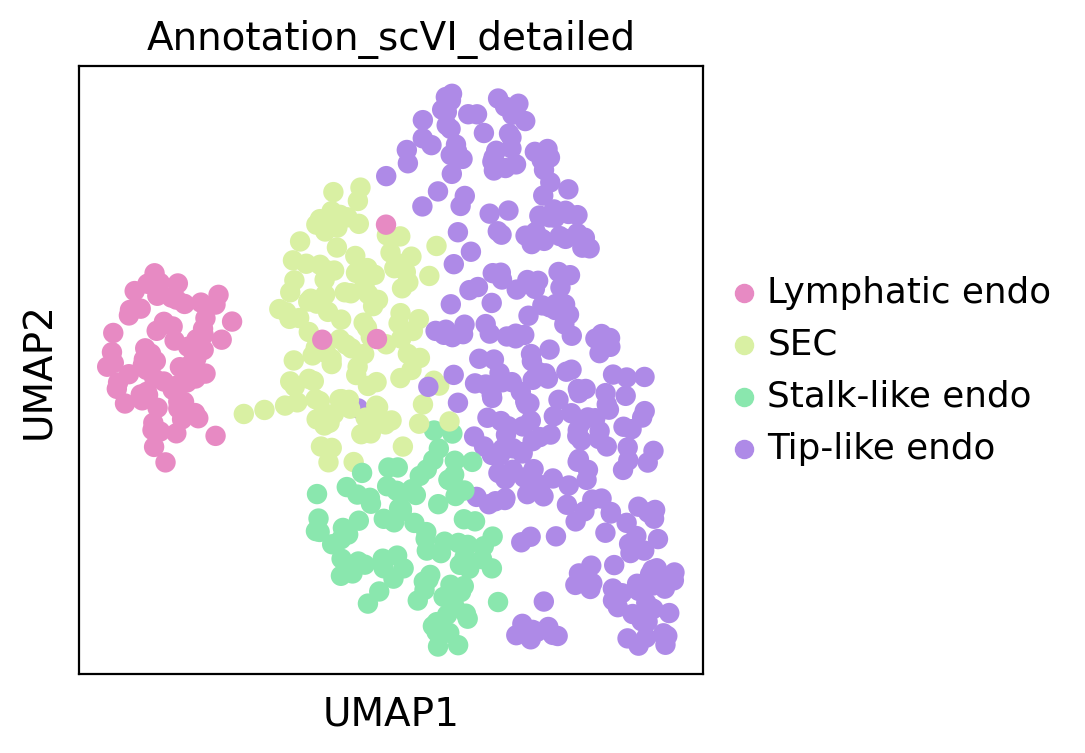

In [7]:
sc.pl.umap(
    adata,
    color="Annotation_scVI_detailed",
    show=True,
    legend_loc="right margin",
    save="annotations.pdf",
)

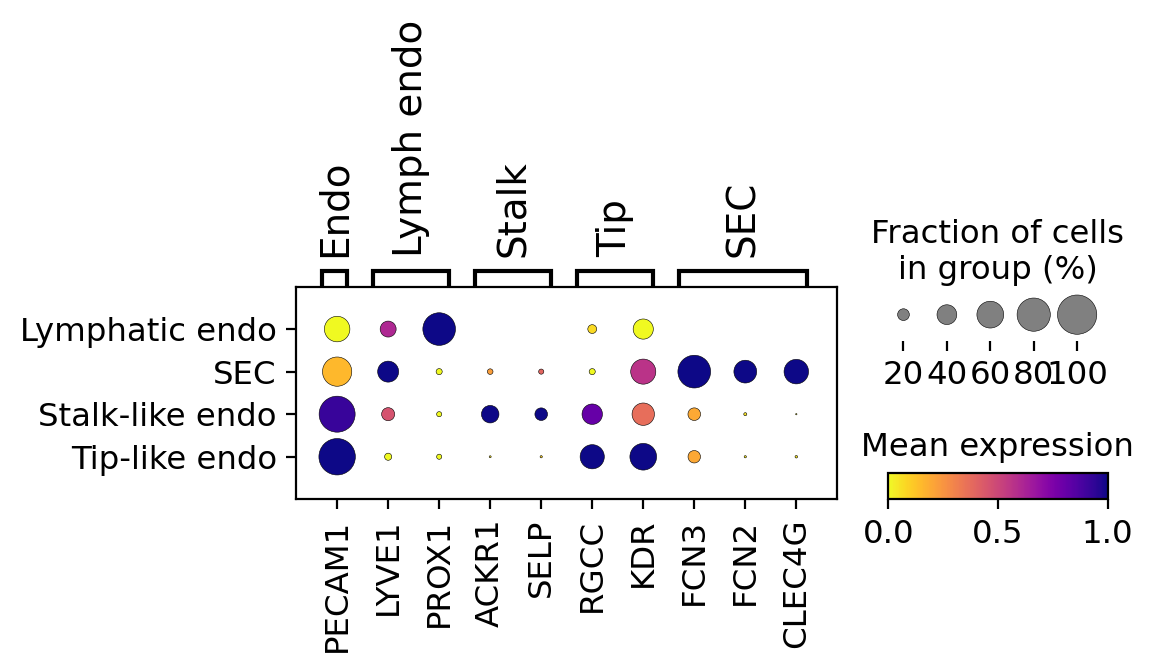

In [8]:
markers_final = {
    "Endo": ["PECAM1"],
    "Lymph endo": ["LYVE1", "PROX1"],
    "Stalk": ["ACKR1", "SELP"],
    "Tip": ["RGCC", "KDR"],
    "SEC": ["FCN3", "FCN2", "CLEC4G"],  # 'F8', 'CD9', 'SPARCL1', 'TM4SF1']
}

sc.pl.dotplot(
    adata,
    groupby="Annotation_scVI_detailed",
    use_raw=True,
    var_names=markers_final,
    cmap="plasma_r",
    standard_scale="var",
    vmin=0,
    vmax=1,
    colorbar_title="Mean expression",
    dendrogram=False,
    save="dotplot_annot_mean_general.pdf",
    show=True,
)

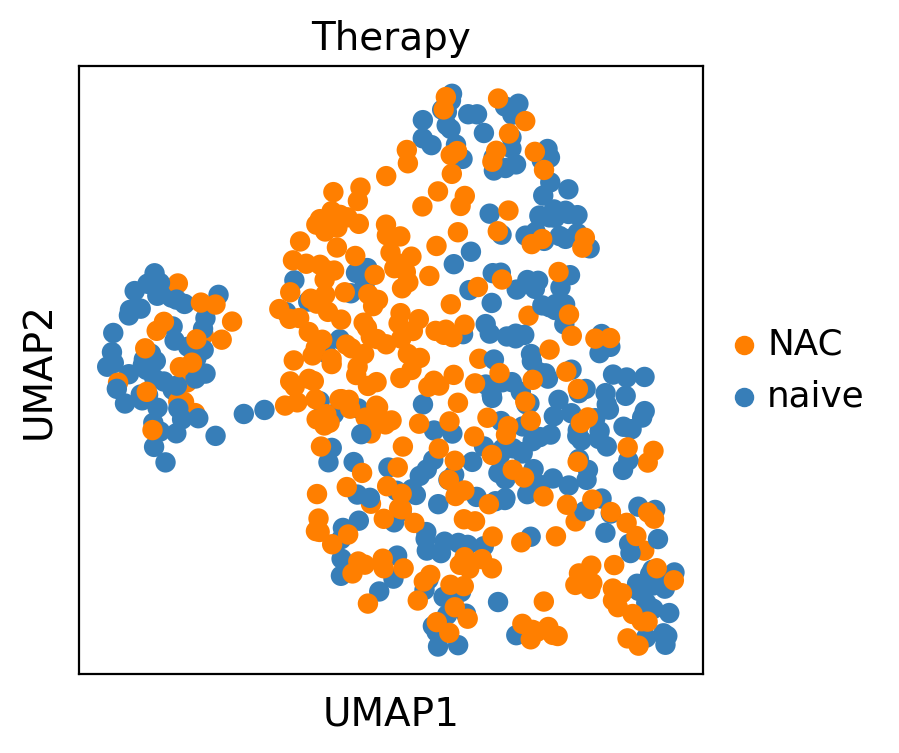

In [9]:
sc.pl.umap(
    adata, color="Therapy", show=True, legend_loc="right margin", save="therapy.pdf"
)

In [10]:
adata.obs.Annotation_scVI_detailed.value_counts()

Tip-like endo      273
SEC                120
Stalk-like endo     91
Lymphatic endo      73
Name: Annotation_scVI_detailed, dtype: int64

### write to file

In [11]:
# write to file
adata.write(
    DIR2SAVE.joinpath(
        "Multiome_Che_Wu_CRC_LM_integrated_scvi_hvg_Endothelial_clustering.h5ad"
    )
)

# write csv of annotations
adata.obs["Annotation_scVI_detailed"].to_csv(
    DIR2SAVE.joinpath(
        "Multiome_Che_Wu_CRC_LM_integrated_scvi_hvg_Endothelial_clustering_annotations.txt"
    ),
    sep="\t",
    index=True,
    header=True,
)

In [12]:
adata = sc.read_h5ad(
    DIR2SAVE.joinpath(
        "Multiome_Che_Wu_CRC_LM_integrated_scvi_hvg_Endothelial_clustering.h5ad"
    )
)

In [13]:
from matplotlib.patches import Rectangle


def proportion_cells_patient(
    adata, groupby_labels, xlabel: str, ylabel: str, colors: dict, figname: str
):  # colors
    # compute proportion of cells within each group
    table2plot = (
        adata.reset_index()
        .groupby(groupby_labels)
        .size()
        .groupby(level=0)
        .apply(lambda x: x * 100 / x.sum())
        .unstack()
    )

    fig, ax = plt.subplots(
        nrows=1,
        ncols=1,
        sharey=False,
        sharex=False,
        dpi=DPI,
    )  # figsize=(4, 4))

    print(table2plot)
    table2plot.plot.bar(stacked=True, ax=ax, color=colors.values())  # , color=colors
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.grid(False, which="major", axis="both")  # removes major horizontal gridlinesd

    labels = list(colors.keys())
    l = [Rectangle((0, 0), 0, 0, color=color) for color in list(colors.values())]
    ax.legend(
        l,
        labels,
        loc="upper left",
        bbox_to_anchor=(1, 0.8),
        facecolor="white",
        edgecolor="white",
        ncol=1,
        borderaxespad=0.0,
        framealpha=0,
        frameon=False,
    )

    plt.savefig(FIG2SAVE.joinpath(figname), dpi=DPI, format="pdf", bbox_inches="tight")
    plt.show()

cell_source               BCI-Nuclei  Che-Cells
Annotation_scVI_detailed                       
Lymphatic endo             84.931507  15.068493
SEC                        94.166667   5.833333
Stalk-like endo            80.219780  19.780220
Tip-like endo              88.278388  11.721612


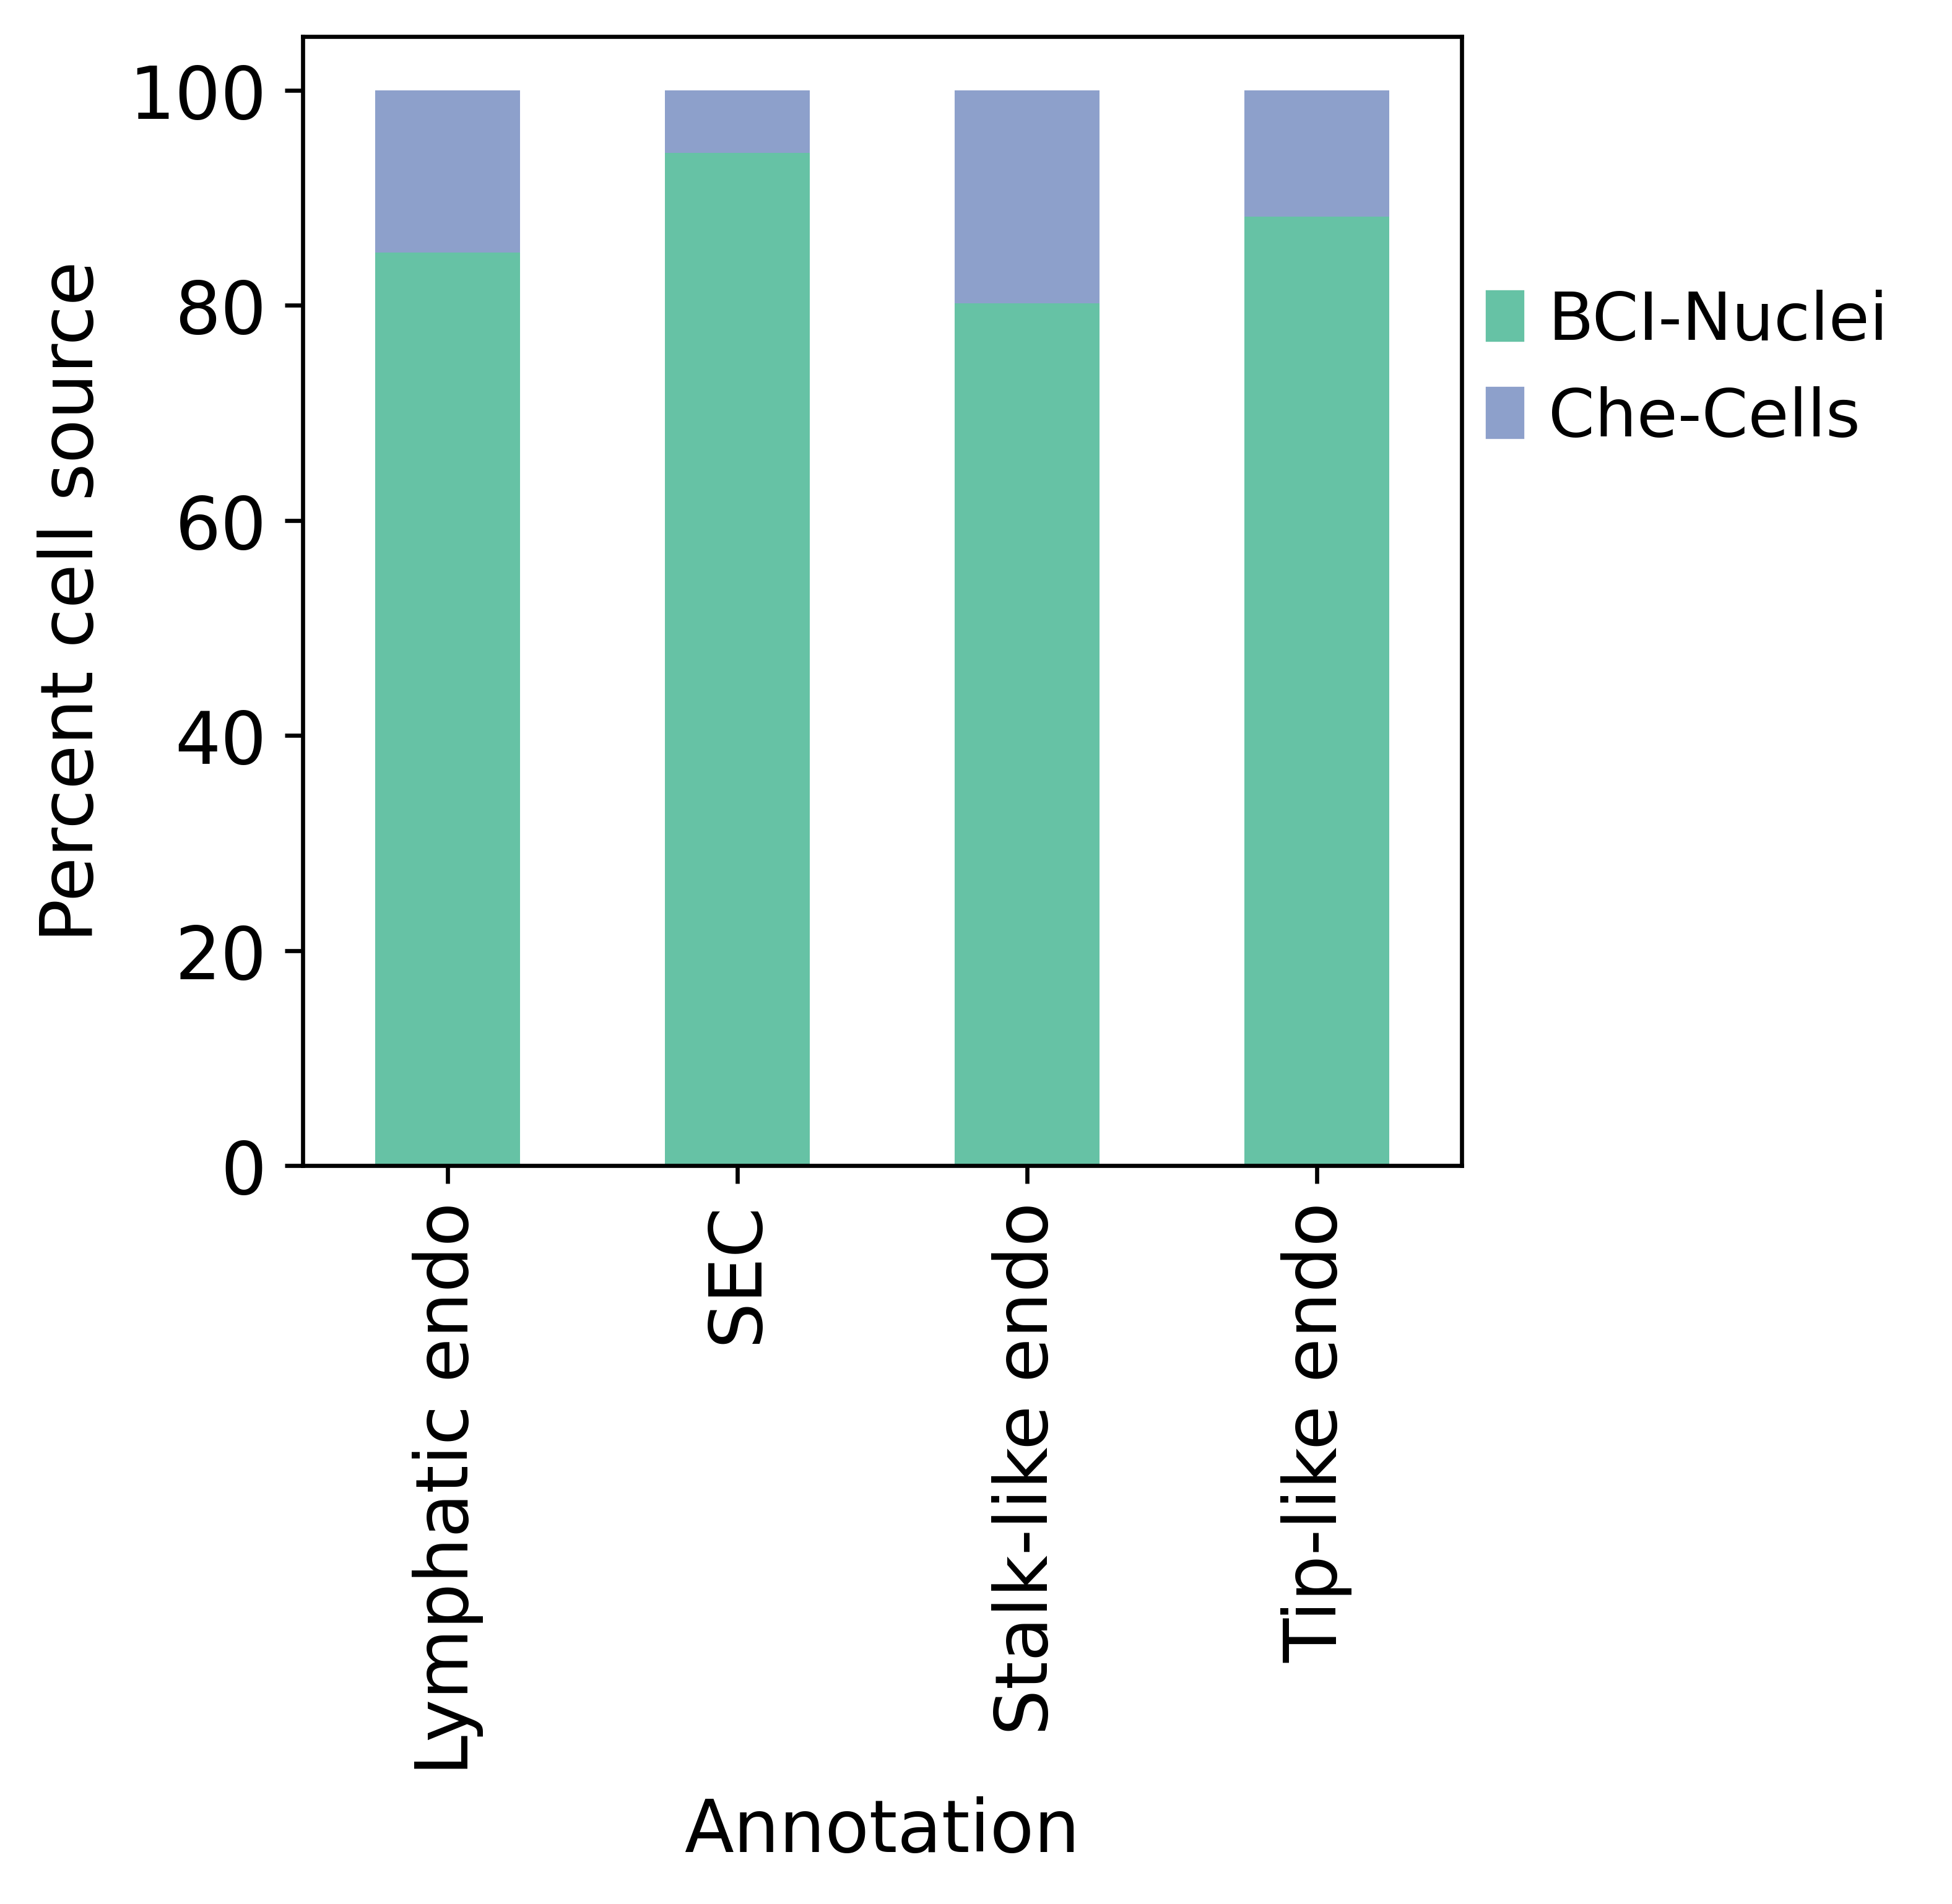

In [14]:
from collections import OrderedDict

color_dict = OrderedDict(
    zip(
        adata.obs["cell_source"].cat.categories.values.tolist(),
        adata.uns["cell_source_colors"],
    )
)

proportion_cells_patient(
    adata.obs,
    groupby_labels=["Annotation_scVI_detailed", "cell_source"],
    xlabel="Annotation",
    ylabel="Percent cell source",
    colors=color_dict,
    figname="annotation_cell_source.pdf",
)

#### Barplots chemotreated vs naive in metastasis 

In [15]:
from matplotlib.patches import Rectangle


def proportion_cells_patient(
    adata, groupby_labels, xlabel: str, ylabel: str, plot2save, colors: dict
):  # colors
    # compute proportion of cells within each group
    table2plot = (
        adata.reset_index()
        .groupby(groupby_labels)
        .size()
        .groupby(level=0)
        .apply(lambda x: x * 100 / x.sum())
        .unstack()
    )

    fig, ax = plt.subplots(
        nrows=1, ncols=1, sharey=False, sharex=False, dpi=DPI
    )  # , figsize=(4, 4))

    print(table2plot)

    table2plot.plot.bar(stacked=True, ax=ax, color=colors.values())  # , color=colors

    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.grid(False, which="major", axis="both")  # removes major horizontal gridlinesd

    labels = list(colors.keys())

    l = [Rectangle((0, 0), 0, 0, color=color) for color in list(colors.values())]

    ax.legend(
        l,
        labels,
        loc="upper left",
        bbox_to_anchor=(1, 0.8),
        facecolor="white",
        edgecolor="white",
        ncol=1,
        borderaxespad=0.0,
        framealpha=0,
        frameon=False,
    )

    plt.savefig(
        plot2save,
        dpi=DPI,
        format="png",
        facecolor="w",
        transparent=True,
        edgecolor="w",
        # orientation='landscape'
    )

    plt.show()

In [16]:
from collections import OrderedDict

color_dict = OrderedDict(
    zip(
        adata.obs["Annotation_scVI_detailed"].cat.categories.values.tolist(),
        adata.uns["Annotation_scVI_detailed_colors"],
    )
)

Annotation_scVI_detailed  Lymphatic endo        SEC  Stalk-like endo  \
Therapy                                                                
NAC                             8.058608  37.362637        16.849817   
naive                          17.957746   6.338028        15.845070   

Annotation_scVI_detailed  Tip-like endo  
Therapy                                  
NAC                           37.728938  
naive                         59.859155  


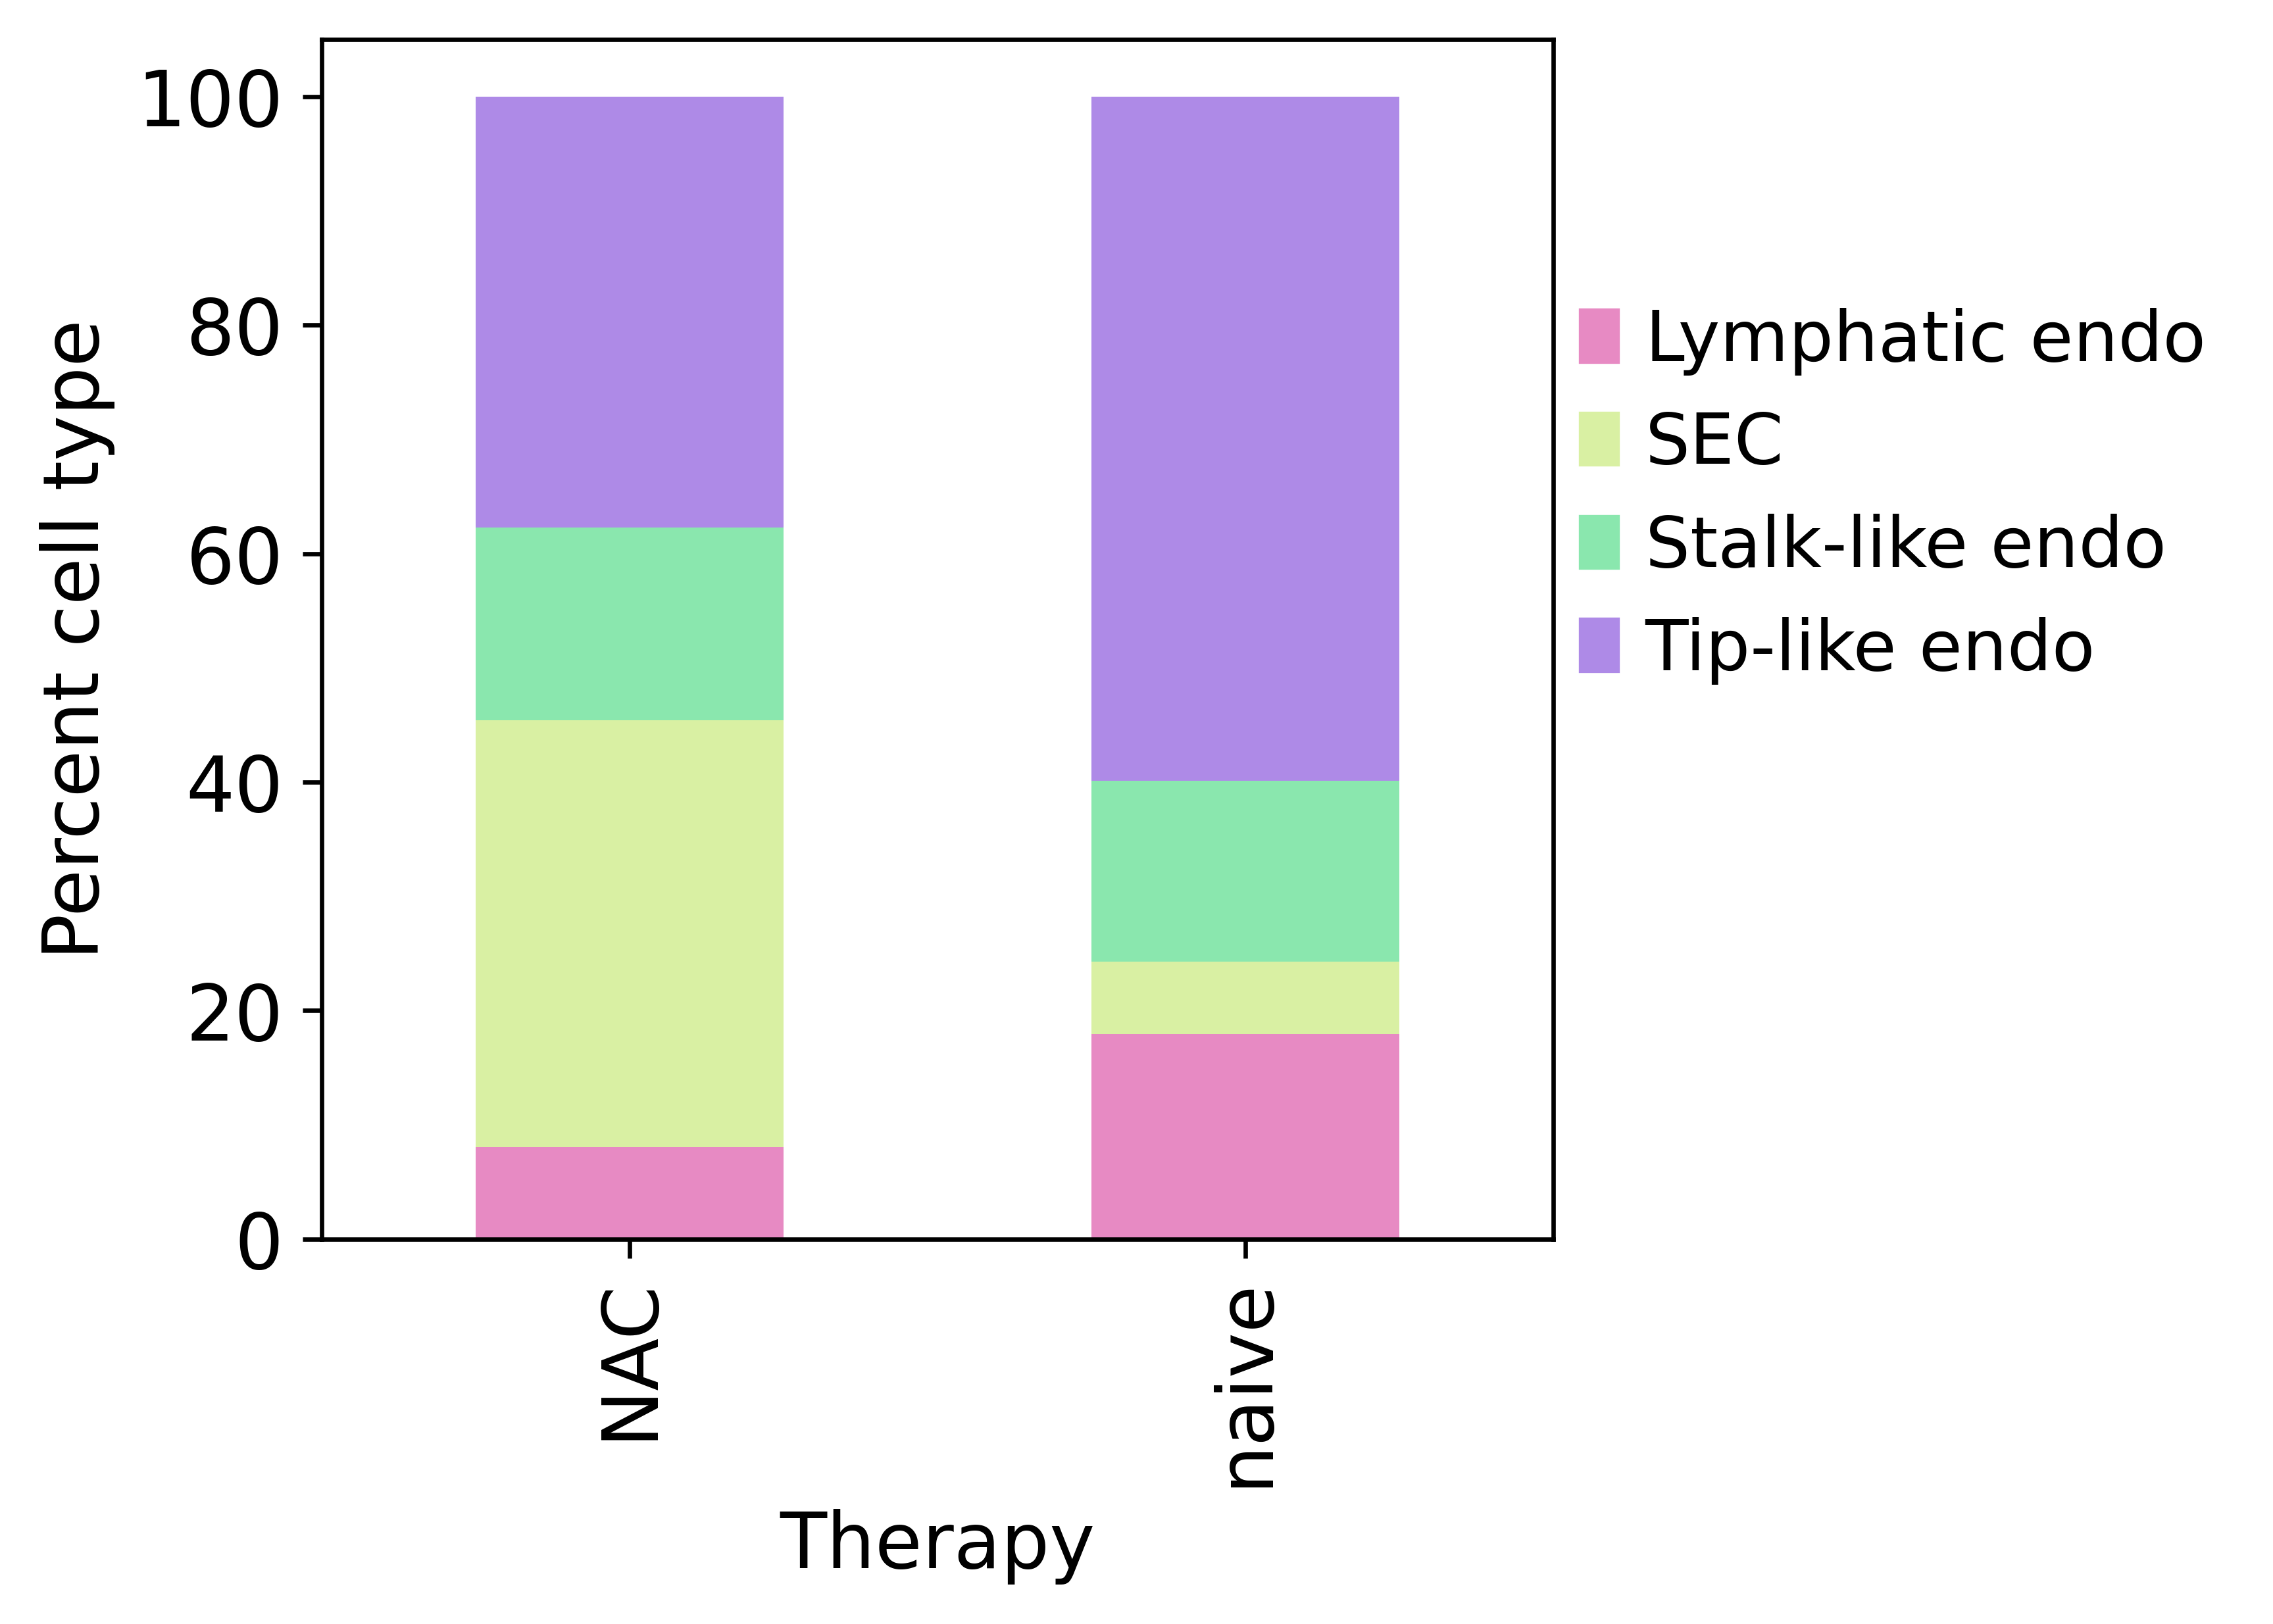

In [17]:
proportion_cells_patient(
    adata.obs,
    groupby_labels=["Therapy", "Annotation_scVI_detailed"],
    xlabel="Therapy",
    ylabel="Percent cell type",
    colors=color_dict,
    plot2save=FIG2SAVE.joinpath("Barplot_therapy_celltypes.png"),
)